## Set up the drive path

In [0]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# !mkdir -p drive
# !google-drive-ocamlfuse drive

In [5]:
ls

adc.json  drive/  sample_data/


In [6]:
cd drive/atten_resi_dcnn

/content/drive/atten_resi_dcnn


## Import Library

In [0]:
import collections
import os
import sys

import tensorflow as tf
import numpy as np

from tensorflow.contrib.seq2seq import sequence_loss

import math
import re
import matplotlib.pyplot as plt

import pickle

!pip install -q mosestokenizer
from mosestokenizer import *

from nltk.translate.bleu_score import sentence_bleu


from scipy.stats import multivariate_normal
from scipy.stats import norm
import copy

## Data Pre-processing

In [0]:
## load vocab dict from txt file

f = open("../small_txt/en_word_to_id.txt", "rb")
en_word_to_id = pickle.load(f)
f.close()

f = open("../small_txt/fr_word_to_id.txt", "rb")
fr_word_to_id = pickle.load(f)
f.close()

In [13]:
en_vocab_size = len(en_word_to_id)
fr_vocab_size = len(fr_word_to_id)

en_eos = en_word_to_id['eos']
fr_eos = fr_word_to_id['eos']

print(en_vocab_size)
print(fr_vocab_size)

30772
39578


In [0]:
def _read_words(filename):
  with tf.gfile.GFile(filename, "r") as f: 
    output = f.read().replace("\n", " eos ").replace(".", " .")
    output = re.sub('[0-9]+', 'N', output)
    return output

def _file_to_word_ids(data, word_to_id):
  
  id_list = []
  
  for word in data:
    if word in word_to_id:
      id_list.append(word_to_id[word])
    else:
      id_list.append(1)
          
  return id_list


def preprocess_train_data(pre_data, word_to_id, max_length):
    pre_data_array = np.asarray(pre_data)
    last_start = 0
    data = []
    each_sen_len = []
    
    for i in range(len(pre_data_array)):
        if pre_data_array[i]==word_to_id['eos']:
            if max_length >= len(pre_data_array[last_start:(i+1)]):                
              data.append(pre_data_array[last_start:(i+1)])
              each_sen_len.append(i+1-last_start)              
            else:
              shorten_sentences = pre_data_array[last_start:(last_start+max_length-1)]
              shorten_sentences = np.concatenate((shorten_sentences, np.asarray([word_to_id['eos']])), axis=0)
              data.append(shorten_sentences)
              each_sen_len.append(max_length) 
            
            last_start = i+1
            
    out_sentences = np.full([len(data), max_length], word_to_id['<PAD>'], dtype=np.int32)
    for i in range(len(data)):
        out_sentences[i,:len(data[i])] = data[i]    
    return out_sentences, np.asarray(each_sen_len)

In [0]:
def generate_input_en(en_file, en_word_to_id, max_length):
  
    en_data = _read_words(en_file)

    en_tokenize = MosesTokenizer('en')

    en_data = en_tokenize(en_data)

    en_data_id = _file_to_word_ids(en_data, en_word_to_id)

    en_input, en_input_len = preprocess_train_data(en_data_id, en_word_to_id, max_length)
    
    return en_input, en_input_len
  
  
  
def generate_output_fr(fr_file, fr_word_to_id, max_length):
    
    fr_data = _read_words(fr_file)

    fr_tokenize = MosesTokenizer('fr')

    fr_data = fr_tokenize(fr_data)

    fr_data_id = _file_to_word_ids(fr_data, fr_word_to_id)

    fr_output, fr_output_len = preprocess_train_data(fr_data_id, fr_word_to_id,max_length=30)

    #out_beg_token = fr_word_to_id['<beg>']*np.ones((fr_output.shape[0], 1), dtype=np.int32)

    #fr_output = np.concatenate((out_beg_token, fr_output), axis=1)

    return fr_output,fr_output_len

In [0]:
def batch_producer(raw_data, raw_data_len, batch_size):    
    data_len = len(raw_data)    
    batch_len = data_len // batch_size    
    data = np.reshape(raw_data[0 : batch_size * batch_len, :], [batch_size, batch_len, -1])
    data = np.transpose(data, (1,0,2))
    
    data_length = np.reshape(raw_data_len[0 : batch_size * batch_len], [batch_size, batch_len])
    data_length = np.transpose(data_length, (1,0))
    return data, data_length 

In [0]:
en_oov_id = en_word_to_id['<OOV>']
fr_oov_id = fr_word_to_id['<OOV>']

def dropout_func(decode_input, dropout_prob, oov_id):
  for i in range(decode_input.shape[0]):
    for j in range(decode_input.shape[1]):
        for k in range(1,decode_input.shape[2]):
            if np.random.uniform() > dropout_prob:
                decode_input[i,j,k] = oov_id        
  return decode_input

## Model

In [0]:
###################### define parameters ######################

max_length = 30

batch_size = 100

embed_size = 300

infer_hidden_size = 1000

latent_size = 200

latent_num = 1

In [0]:
# ###################### generate sentence #######################
batch_size = 1

latent_num = 50

In [0]:
###################### define placeholder ######################

input_placeholder = tf.placeholder(tf.int32, [batch_size, max_length], 'input')         # batch_size x max_length

target_placeholder = tf.placeholder(tf.int32, [batch_size, max_length], 'target')       # batch_size x max_length

in_length_placeholder = tf.placeholder(tf.int32, [batch_size, ], 'in_len')              # batch_size x 1

out_length_placeholder = tf.placeholder(tf.int32, [batch_size, ], 'out_len')            # batch_size x 1

discount_placeholder = tf.placeholder(tf.float32, name='discount')

lr_placeholder = tf.placeholder(tf.float32, name='learn_rate')

input_drop_placeholder = tf.placeholder(tf.int32, [batch_size, max_length], 'input_drop')   # batch_size x max_length

target_drop_placeholder = tf.placeholder(tf.int32, [batch_size, max_length], 'target_drop') # batch_size x max_length

if_gene_placeholder = tf.placeholder(tf.bool, name='if_gene')

latent_var_placeholder = tf.placeholder(tf.float32, [latent_num, batch_size, max_length, latent_size], 'la_var')       # batch_size x max_length x latent_size

xavier_initializer = tf.contrib.layers.xavier_initializer()

In [0]:
##################### embedding look-up for input sentences ####################

with tf.variable_scope('en_embedding'):
    en_embedding = tf.get_variable('en_embeding',[en_vocab_size, embed_size], dtype=tf.float32, initializer=xavier_initializer)
    inputs = tf.nn.embedding_lookup(en_embedding, input_placeholder)                      # batch_size x max_length x embed_size
    inputs_drop = tf.nn.embedding_lookup(en_embedding, input_drop_placeholder)                      # batch_size x max_length x embed_size
    

with tf.variable_scope('fr_embedding'):
    fr_embedding = tf.get_variable('fr_embeding',[fr_vocab_size, embed_size], dtype=tf.float32, initializer=xavier_initializer)
    targets = tf.nn.embedding_lookup(fr_embedding, target_placeholder)                      # batch_size x max_length x embed_size
    targets_drop = tf.nn.embedding_lookup(fr_embedding, target_drop_placeholder)                      # batch_size x max_length x embed_size
    

## 1 Inference Model - Encoder

$q(z_1, z_2, ... , z_T|x,y)$

Similar to the encoder of RNNSearch

In [0]:
#################### Inference model  #######################

encode_inputs = tf.transpose(tf.concat([inputs, targets], axis=2), (1,0,2))

with tf.variable_scope('encode'):
    #basic_cell =tf.contrib.rnn.GRUCell(infer_hidden_size)
    basic_cell = tf.contrib.rnn.BasicLSTMCell(infer_hidden_size, forget_bias=1.0, state_is_tuple=True)
    init_state = basic_cell.zero_state(batch_size, tf.float32)
    encode_outputs, encode_state = tf.nn.bidirectional_dynamic_rnn(cell_fw=basic_cell, 
                                                                   cell_bw=basic_cell, 
                                                                   inputs=encode_inputs,                                                                
                                                                   initial_state_fw=init_state,
                                                                   initial_state_bw=init_state,
                                                                   dtype=tf.float32,
                                                                   time_major=True)

In [0]:
#### encode_outputs: max_length x batch_size x infer_hidden_size

en_outputs = tf.concat((encode_outputs[0],encode_outputs[1]),2)                             # max_length x batch_size x 2*infer_hidden_size

en_outputs_tran = tf.transpose(en_outputs, (1,0,2))                                         # batch_size x en_max_length x 2*infer_hidden_size

en_outputs_resh = tf.reshape(en_outputs_tran, (batch_size*max_length, 2*infer_hidden_size))

In [0]:
# ##################### Inference model  #######################

# ##################### bi-direction lstm of source sentence ######################

# encode_inputs_x = tf.transpose(inputs, (1,0,2))  # en_max_length x batch_size x embed_size
  
# with tf.variable_scope('encode_x'):
#     basic_cell_x = tf.contrib.rnn.BasicLSTMCell(infer_hidden_size, forget_bias=1.0, state_is_tuple=True)
#     init_state_x = basic_cell_x.zero_state(batch_size, tf.float32)
#     encode_outputs_x, encode_state_x = tf.nn.bidirectional_dynamic_rnn(cell_fw=basic_cell_x, 
#                                                                        cell_bw=basic_cell_x, 
#                                                                        inputs=encode_inputs_x,
#                                                                        sequence_length=in_length_placeholder,
#                                                                        initial_state_fw=init_state_x,
#                                                                        initial_state_bw=init_state_x,
#                                                                        dtype=tf.float32,
#                                                                        time_major=True)
# #### encode_outputs_x: max_length x batch_size x infer_hidden_size




# ##################### bi-direction lstm of target sentence ######################

# encode_inputs_y = tf.transpose(targets, (1,0,2))  # en_max_length x batch_size x embed_size
  
# with tf.variable_scope('encode_y'):
#     basic_cell_y = tf.contrib.rnn.BasicLSTMCell(infer_hidden_size, forget_bias=1.0, state_is_tuple=True)
#     init_state_y = basic_cell_y.zero_state(batch_size, tf.float32)
#     encode_outputs_y, encode_state_y = tf.nn.bidirectional_dynamic_rnn(cell_fw=basic_cell_y, 
#                                                                        cell_bw=basic_cell_y, 
#                                                                        inputs=encode_inputs_y,
#                                                                        sequence_length=out_length_placeholder,
#                                                                        initial_state_fw=init_state_y,
#                                                                        initial_state_bw=init_state_y,
#                                                                        dtype=tf.float32,
#                                                                        time_major=True)
# #### encode_outputs_y: max_length x batch_size x infer_hidden_size

In [0]:
# #### encode_outputs: max_length x batch_size x infer_hidden_size

# en_outputs = tf.concat((encode_outputs[0],encode_outputs[1]),2)                             # max_length x batch_size x 2*infer_hidden_size

# en_outputs_tran = tf.transpose(en_outputs, (1,0,2))                                         # batch_size x en_max_length x 2*infer_hidden_size

# #en_outputs_resh = tf.reshape(en_outputs_tran, (batch_size*max_length, 2*infer_hidden_size)) # batch_size*max_length x 2*infer_hidden_size

# ##################### concatenate the state of encoder of x and y ######################

# fw_bw_en_state_x = tf.concat((encode_state_x[0][1],encode_state_x[1][1]),1)     # en_max_length x  2*infer_hidden_size

# fw_bw_en_state_y = tf.concat((encode_state_y[0][1],encode_state_y[1][1]),1)     # en_max_length x  2*infer_hidden_size

# fw_bw_en_state = tf.concat((fw_bw_en_state_x, fw_bw_en_state_y), 1)             # en_max_length x  4*infer_hidden_size

# fw_bw_en_state = tf.tile(tf.expand_dims(fw_bw_en_state, axis=1), (1,30,1))


# fw_bw_en = tf.concat((fw_bw_en_state, en_outputs_tran), axis=2)

# fw_bw_en = tf.reshape(fw_bw_en, (batch_size*max_length, 6*infer_hidden_size))

In [0]:
with tf.variable_scope('encode_projection'):
    W_1 = tf.get_variable('W_1',[2*infer_hidden_size, latent_size], dtype=tf.float32, initializer=xavier_initializer)
    b_1 = tf.get_variable('b_1',[latent_size,], dtype=tf.float32, initializer=xavier_initializer)
    W_2 = tf.get_variable('W_2',[2*infer_hidden_size, latent_size], dtype=tf.float32, initializer=xavier_initializer)
    b_2 = tf.get_variable('b_2',[latent_size,], dtype=tf.float32, initializer=xavier_initializer)

In [0]:
#fw_bw_en_outputs_norm = tf.contrib.layers.batch_norm(fw_bw_en_outputs_resh, center=True, scale=True)

la_mean = tf.matmul(en_outputs_resh, W_1) + b_1                              # batch_size*max_length x latent_size 

la_log_var = tf.matmul(en_outputs_resh, W_2) + b_2                           # batch_size*max_length x latent_size 
la_var = tf.exp(la_log_var)
la_std = tf.sqrt(la_var)

kl_div_loss = 1 + la_log_var - tf.square(la_mean) - la_var                      # batch_size*max_length x latent_size
kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, axis=1)                         # batch_size*max_length x 1
kl_div_loss = tf.reshape(kl_div_loss, (batch_size, max_length))                 # batch_size x max_length
kl_div_loss = tf.reduce_sum(kl_div_loss, axis=1)

In [0]:
# latent_variables_v = []
# for _ in range(latent_num):
#   eposida = tf.random_normal(tf.shape(la_std), mean=0.0,stddev=1)
#   latent_variables_sample = la_mean + la_std*eposida
#   latent_variables_sample = tf.reshape(latent_variables_sample, (batch_size, max_length, latent_size))    # batch_size x max_length x latent_size
#   latent_variables_v.append(latent_variables_sample)

# def if_true():
#   latent_v = []
#   for h in range(latent_num):
#     latent_v.append(latent_var_placeholder[h])
#   return latent_v

# def if_false():
#   return latent_variables_v

# latent_variables = tf.cond(if_gene_placeholder, if_true, if_false)

# if latent_num == 1:
#   new_latent_variables = []
#   new_latent_variables.append(latent_variables)
#   latent_variables = new_latent_variables

In [0]:
latent_v = []
for h in range(latent_num):
  latent_v.append(latent_var_placeholder[h])
    
latent_variables = latent_v

## 2 Generation Model - Decoder

$p_\theta(x|z_1, z_2, ... , z_T)$

$p_\theta(y|z_1, z_2, ... , z_T)$

In [0]:
filter_num = 150

filter_size = 3

filter_size_only_pre = 2

filter_size_pad = filter_size - filter_size_only_pre

filter_zero_pad = tf.zeros(shape=[filter_size_pad, embed_size+latent_size, filter_num], dtype=tf.float32)
filter_zero_pad_2 = tf.zeros(shape=[1, filter_size_pad, filter_num, filter_num], dtype=tf.float32)

## X decoder

In [0]:
atten_size = 1000
maxout_size = 500

with tf.variable_scope('x_con_dialted_1D'):
  
    f_x_1 = tf.get_variable("x_filter_1", shape=[3, latent_size+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_x_1_dia = tf.concat([f_x_1, 
                           tf.zeros((2,latent_size+latent_size,filter_num))], axis=0)                                     
    # 3 x (embed_size+latent_size) x filter_num
    
    f_x_2 = tf.get_variable("x_filter_2", shape=[3, latent_size+filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_x_2_dia = tf.concat([tf.reshape(f_x_2[0],(1,latent_size+filter_num,filter_num)), 
                           tf.zeros((1,latent_size+filter_num,filter_num)), 
                           tf.reshape(f_x_2[1],(1,latent_size+filter_num,filter_num)), 
                           tf.zeros((1,latent_size+filter_num,filter_num)),
                           tf.reshape(f_x_2[2],(1,latent_size+filter_num,filter_num)),
                           tf.zeros((4,latent_size+filter_num,filter_num)),], axis=0)
    # 9 x filter_num x filter_num
    
    f_x_3 = tf.get_variable("x_filter_3", shape=[3, latent_size+filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_x_3_dia = tf.concat([tf.reshape(f_x_3[0],(1,latent_size+filter_num,filter_num)), 
                           tf.zeros((3,latent_size+filter_num,filter_num)), 
                           tf.reshape(f_x_3[1],(1,latent_size+filter_num,filter_num)), 
                           tf.zeros((3,latent_size+filter_num,filter_num)),
                           tf.reshape(f_x_3[2],(1,latent_size+filter_num,filter_num)),
                           tf.zeros((8,latent_size+filter_num,filter_num))], axis=0)
    # 13 x filter_num x filter_num
    
    f_x_4 = tf.get_variable("x_filter_4", shape=[3, latent_size+filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_x_4_dia = tf.concat([tf.reshape(f_x_4[0],(1,latent_size+filter_num,filter_num)), 
                           tf.zeros((7,latent_size+filter_num,filter_num)), 
                           tf.reshape(f_x_4[1],(1,latent_size+filter_num,filter_num)), 
                           tf.zeros((7,latent_size+filter_num,filter_num)),
                           tf.reshape(f_x_4[2],(1,latent_size+filter_num,filter_num)),
                           tf.zeros((16,latent_size+filter_num,filter_num))], axis=0)
    # 21 x filter_num x filter_num

    
#### variablen of a FC layer to map the hidden state of the decoder-rnn in each time-step to the predicted next word
with tf.variable_scope('projection_x'):
    proj_w_x = tf.get_variable('project_w_x', [maxout_size,embed_size], dtype=tf.float32, initializer=xavier_initializer)
    proj_b_x = tf.get_variable('project_b_x', [embed_size,], dtype=tf.float32, initializer=xavier_initializer)
    
#### sequence weight of x
squence_weight_x= tf.sequence_mask(in_length_placeholder, maxlen=max_length, dtype=tf.float32)                       # batch_size x max_length

#### attention model ####
with tf.variable_scope('encode_projection_x'):
    U_a_x = tf.get_variable('U_a_x',[latent_size, atten_size], dtype=tf.float32, initializer=xavier_initializer)
    W_a_x = tf.get_variable('W_a_x',[embed_size, atten_size], dtype=tf.float32, initializer=xavier_initializer)
    V_a_x = tf.get_variable('V_a_x',[atten_size,1], dtype=tf.float32, initializer=xavier_initializer)
    
#### maxout model ####
with tf.variable_scope('x_probability'):
    U_o_x = tf.get_variable('U_o_x',[filter_num, 2*maxout_size], dtype=tf.float32, initializer=xavier_initializer)
    V_o_x = tf.get_variable('V_o_x',[latent_size,  2*maxout_size], dtype=tf.float32, initializer=xavier_initializer)
    C_o_x = tf.get_variable('C_o_x',[latent_size, 2*maxout_size], dtype=tf.float32, initializer=xavier_initializer)

In [0]:
#beg_token_x = tf.zeros((1,embed_size))
beg_token_x = tf.reshape(en_embedding[en_eos], [1,embed_size])

x_list = tf.split(inputs, axis=0, num_or_size_splits=batch_size)

x_with_beg_list = [tf.concat((beg_token_x, input[0]), axis=0) for input in x_list]              # batch_size x (max_length+1) x embed_size

x_with_beg = tf.stack(x_with_beg_list, axis=0)

WaXi_1 = tf.matmul(tf.reshape(x_with_beg[:,:30,:], (batch_size*max_length, embed_size)), W_a_x)   # batch_size*max_length x atten_size

WaXi_1 = tf.reshape(WaXi_1, (batch_size, max_length, atten_size))                               #  batch_size x max_length x atten_size

In [0]:
def x_decoder(WaXi_1, de_latent):

  UaZj = tf.matmul(tf.reshape(de_latent, (batch_size*max_length, latent_size)), U_a_x)    # batch_size*max_length x atten_size

  context_c = []       # batch_size x max_length x latent_size

  for t in range(max_length):
    WaX0_allsteps = tf.tile(WaXi_1[:,t,:], (max_length,1)) # batch_size*max_length x atten_size

    e_1j = tf.reshape(tf.matmul(tf.nn.tanh(WaX0_allsteps + UaZj), V_a_x), (batch_size, max_length))
  
    alpha_1j = tf.nn.softmax(e_1j)
    alpha_1j_reshaped = tf.reshape(alpha_1j,(batch_size*max_length,1))         # batch_size*en_max_length x 1
  
    c_1j = alpha_1j_reshaped*tf.reshape(de_latent, (batch_size*max_length, latent_size))
    c_1 = tf.reduce_sum(tf.reshape(c_1j, (batch_size, max_length, latent_size)), axis=1)
  
    context_c.append(c_1)
  
  context_c = tf.stack(context_c, axis=1)
      
  x_out_conv_dia_1 = tf.nn.conv1d(tf.concat((de_latent, context_c), axis=2),
                                  f_x_1_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  x_out_conv_dia_2 = tf.nn.conv1d(tf.concat((de_latent, x_out_conv_dia_1), axis=2),
                                  f_x_2_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  x_out_conv_dia_3 = tf.nn.conv1d(tf.concat((de_latent, x_out_conv_dia_2), axis=2), 
                                  f_x_3_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  x_out_conv_dia_4 = tf.nn.conv1d(tf.concat((de_latent, x_out_conv_dia_3), axis=2), 
                                  f_x_4_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  
  x_out_conv_dia = tf.reshape(x_out_conv_dia_4, (batch_size*max_length, filter_num))
  de_latent_resh = tf.reshape(de_latent, (batch_size*max_length, latent_size))
  context_c_resh = tf.reshape(de_latent, (batch_size*max_length, latent_size))
  
  #### Maxout layer
  tt_1 = tf.matmul(x_out_conv_dia, U_o_x) #+ tf.matmul(de_latent_resh, V_o_x) + tf.matmul(context_c_resh, C_o_x)       # batch_size*max_length x 2*maxout_size
  t_1 = tf.contrib.layers.maxout(tt_1,maxout_size,axis=-1)                                                      # batch_size*max_length x maxout_size
  
  x_out_project = tf.matmul(t_1, proj_w_x) + proj_b_x                                                           # batch_size*max_length x embed_size 
  
  target_x = tf.reduce_sum(x_out_project*tf.reshape(inputs, (batch_size*max_length, embed_size)), axis=1)
  logits_x = tf.matmul(x_out_project, tf.transpose(en_embedding,(1,0)))

  logits_x_re = tf.reshape(logits_x, (batch_size, max_length, en_vocab_size))                                   # batch_size x max_length x fr_vocab_size
  x_max = tf.reshape(tf.reduce_max(logits_x_re, axis=2), (batch_size*max_length, 1))                            # batch_size*max_length x 1

  prob_unnorm_x = tf.exp(tf.reshape(target_x, (batch_size*max_length, 1)) - x_max)                                                                      # batch_size*max_length x 1
  prob_constant_x = tf.exp(logits_x - tf.tile(x_max,(1, en_vocab_size)))                                        # batch_size*max_length x fr_vocab_size
                                           
  prob_norm_x = prob_unnorm_x/tf.reshape(tf.reduce_sum(prob_constant_x, axis=1), (batch_size*max_length, 1))              # batch_size*max_length x 1
  prob_norm_x = tf.reshape(prob_norm_x, (batch_size, max_length))                                                         # batch_size x max_length
  log_prob_norm_x = tf.log(tf.clip_by_value(prob_norm_x,1e-8,1.0))                                                        # batch_size x max_length

  log_liki_x = tf.reduce_sum(log_prob_norm_x*squence_weight_x, axis=1)                                                    # batch_size x 1
  return log_liki_x

log_liki_x_to = []
for l in range(latent_num):
  log_liki_x_to.append(x_decoder(WaXi_1,latent_variables[l]))
log_liki_x_to = tf.stack(log_liki_x_to, axis=0)
  

In [0]:
def x_decoder_gene(WaXi_1, de_latent):

  UaZj = tf.matmul(tf.reshape(de_latent, (batch_size*max_length, latent_size)), U_a_x)    # batch_size*max_length x atten_size

  context_c = []       # batch_size x max_length x latent_size

  for t in range(max_length):
    WaX0_allsteps = tf.tile(WaXi_1[:,t,:], (max_length,1)) # batch_size*max_length x atten_size

    e_1j = tf.reshape(tf.matmul(tf.nn.tanh(WaX0_allsteps + UaZj), V_a_x), (batch_size, max_length))
  
    alpha_1j = tf.nn.softmax(e_1j)
    alpha_1j_reshaped = tf.reshape(alpha_1j,(batch_size*max_length,1))         # batch_size*en_max_length x 1
  
    c_1j = alpha_1j_reshaped*tf.reshape(de_latent, (batch_size*max_length, latent_size))
    c_1 = tf.reduce_sum(tf.reshape(c_1j, (batch_size, max_length, latent_size)), axis=1)
  
    context_c.append(c_1)
  
  context_c = tf.stack(context_c, axis=1)
  
  x_out_conv_dia_1 = tf.nn.conv1d(tf.concat((de_latent, context_c), axis=2), 
                                  f_x_1_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  x_out_conv_dia_2 = tf.nn.conv1d(tf.concat((de_latent, x_out_conv_dia_1), axis=2),
                                  f_x_2_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  x_out_conv_dia_3 = tf.nn.conv1d(tf.concat((de_latent, x_out_conv_dia_2), axis=2), 
                                  f_x_3_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  x_out_conv_dia_4 = tf.nn.conv1d(tf.concat((de_latent, x_out_conv_dia_3), axis=2), 
                                  f_x_4_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  
  x_out_conv_dia = tf.reshape(x_out_conv_dia_4, (batch_size*max_length, filter_num))
  de_latent_resh = tf.reshape(de_latent, (batch_size*max_length, latent_size))
  #context_c_resh = tf.reshape(de_latent, (batch_size*max_length, latent_size))
  
  #### Maxout layer
  tt_1 = tf.matmul(x_out_conv_dia, U_o_x) + tf.matmul(de_latent_resh, V_o_x) #+ tf.matmul(context_c_resh, C_o_x)       # batch_size*max_length x 2*maxout_size
  t_1 = tf.contrib.layers.maxout(tt_1,maxout_size,axis=-1)                                                      # batch_size*max_length x maxout_size
  
  x_out_project = tf.matmul(t_1, proj_w_x) + proj_b_x                                                           # batch_size*max_length x embed_size 
  
  logits_x = tf.matmul(x_out_project, tf.transpose(en_embedding,(1,0)))
                                               
  return logits_x

logits_gene_x_to = []
for l in range(latent_num):
  logits_gene_x_to.append(x_decoder_gene(WaXi_1,latent_variables[l]))
logits_gene_x_to = tf.stack(logits_gene_x_to, axis=0)

## Y decoder

In [0]:
with tf.variable_scope('y_con_dialted_1D'):
  
    f_y_1 = tf.get_variable("y_filter_1", shape=[3, latent_size+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_y_1_dia = tf.concat([f_y_1, 
                           tf.zeros((2, latent_size+latent_size,filter_num))], axis=0)  
                                    
    # 3 x (embed_size+latent_size) x filter_num
    
    f_y_2 = tf.get_variable("y_filter_2", shape=[3, latent_size+filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_y_2_dia = tf.concat([tf.reshape(f_y_2[0],(1,latent_size+filter_num, filter_num)), 
                           tf.zeros((1,latent_size+filter_num,filter_num)), 
                           tf.reshape(f_y_2[1],(1,latent_size+filter_num,filter_num)), 
                           tf.zeros((1,latent_size+filter_num,filter_num)),
                           tf.reshape(f_y_2[2],(1,latent_size+filter_num,filter_num)),
                           tf.zeros((4,latent_size+filter_num,filter_num)),], axis=0)
    # 9 x filter_num x filter_num
    
    f_y_3 = tf.get_variable("y_filter_3", shape=[3, latent_size+filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_y_3_dia = tf.concat([tf.reshape(f_y_3[0],(1,latent_size+filter_num,filter_num)), 
                           tf.zeros((3,latent_size+filter_num,filter_num)), 
                           tf.reshape(f_y_3[1],(1,latent_size+filter_num,filter_num)), 
                           tf.zeros((3,latent_size+filter_num,filter_num)),
                           tf.reshape(f_y_3[2],(1,latent_size+filter_num,filter_num)),
                           tf.zeros((8,latent_size+filter_num,filter_num))], axis=0)
    # 13 x filter_num x filter_num
    
    f_y_4 = tf.get_variable("y_filter_4", shape=[3, latent_size+filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_y_4_dia = tf.concat([tf.reshape(f_y_4[0],(1,latent_size+filter_num,filter_num)), 
                           tf.zeros((7,latent_size+filter_num,filter_num)), 
                           tf.reshape(f_y_4[1],(1,latent_size+filter_num,filter_num)), 
                           tf.zeros((7,latent_size+filter_num,filter_num)),
                           tf.reshape(f_y_4[2],(1,latent_size+filter_num,filter_num)),
                           tf.zeros((16,latent_size+filter_num,filter_num))], axis=0)
    # 21 x filter_num x filter_num

    
    
#### variablen of a FC layer to map the hidden state of the decoder-rnn in each time-step to the predicted next word
with tf.variable_scope('projection_y'):
    proj_w_y = tf.get_variable('project_w_y', [maxout_size,embed_size], dtype=tf.float32, initializer=xavier_initializer)
    proj_b_y = tf.get_variable('project_b_y', [embed_size,], dtype=tf.float32, initializer=xavier_initializer)
    
    
#### sequence weight of y
squence_weight_y = tf.sequence_mask(out_length_placeholder, maxlen=max_length, dtype=tf.float32)                        # batch_size x max_length

#### attention model ####
with tf.variable_scope('encode_projection_y'):
    U_a_y = tf.get_variable('U_a_y',[latent_size, atten_size], dtype=tf.float32, initializer=xavier_initializer)
    W_a_y = tf.get_variable('W_a_y',[embed_size, atten_size], dtype=tf.float32, initializer=xavier_initializer)
    V_a_y = tf.get_variable('V_a_y',[atten_size,1], dtype=tf.float32, initializer=xavier_initializer)
    
#### maxout model ####
with tf.variable_scope('y_probability'):
    U_o_y = tf.get_variable('U_o_y',[filter_num, 2*maxout_size], dtype=tf.float32, initializer=xavier_initializer)
    V_o_y = tf.get_variable('V_o_y',[latent_size,  2*maxout_size], dtype=tf.float32, initializer=xavier_initializer)
    C_o_y = tf.get_variable('C_o_y',[latent_size, 2*maxout_size], dtype=tf.float32, initializer=xavier_initializer)

In [0]:
#beg_token_x = tf.zeros((1,embed_size))
beg_token_y = tf.reshape(fr_embedding[fr_eos], [1,embed_size])

y_list = tf.split(targets, axis=0, num_or_size_splits=batch_size)

y_with_beg_list = [tf.concat((beg_token_y, target[0]), axis=0) for target in y_list]              # batch_size x (max_length+1) x embed_size

y_with_beg = tf.stack(y_with_beg_list, axis=0)

WaYi_1 = tf.matmul(tf.reshape(y_with_beg[:,:30,:], (batch_size*max_length, embed_size)), W_a_y)   # batch_size*max_length x atten_size

WaYi_1 = tf.reshape(WaYi_1, (batch_size, max_length, atten_size))                               #  batch_size x max_length x atten_size

In [0]:
def y_decoder(WaYi_1, de_latent):

  UaZj = tf.matmul(tf.reshape(de_latent, (batch_size*max_length, latent_size)), U_a_y)    # batch_size*max_length x atten_size

  context_c = []       # batch_size x max_length x latent_size

  for t in range(max_length):
    WaY0_allsteps = tf.tile(WaYi_1[:,t,:], (max_length,1)) # batch_size*max_length x atten_size

    e_1j = tf.reshape(tf.matmul(tf.nn.tanh(WaY0_allsteps + UaZj), V_a_y), (batch_size, max_length))
  
    alpha_1j = tf.nn.softmax(e_1j)
    alpha_1j_reshaped = tf.reshape(alpha_1j,(batch_size*max_length,1))         # batch_size*en_max_length x 1
  
    c_1j = alpha_1j_reshaped*tf.reshape(de_latent, (batch_size*max_length, latent_size))
    c_1 = tf.reduce_sum(tf.reshape(c_1j, (batch_size, max_length, latent_size)), axis=1)
  
    context_c.append(c_1)
  
  context_c = tf.stack(context_c, axis=1)
  
  y_out_conv_dia_1 = tf.nn.conv1d(tf.concat((de_latent, context_c), axis=2), 
                                  f_y_1_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  y_out_conv_dia_2 = tf.nn.conv1d(tf.concat((de_latent, y_out_conv_dia_1), axis=2), 
                                  f_y_2_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  y_out_conv_dia_3 = tf.nn.conv1d(tf.concat((de_latent, y_out_conv_dia_2), axis=2),  
                                  f_y_3_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  y_out_conv_dia_4 = tf.nn.conv1d(tf.concat((de_latent, y_out_conv_dia_3), axis=2),  
                                  f_y_4_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  
  
  y_out_conv_dia = tf.reshape(y_out_conv_dia_4, (batch_size*max_length, filter_num))
  de_latent_resh = tf.reshape(de_latent, (batch_size*max_length, latent_size))
  context_c_resh = tf.reshape(de_latent, (batch_size*max_length, latent_size))
  
  #### Maxout layer
  tt_1 = tf.matmul(y_out_conv_dia, U_o_y) #+ tf.matmul(de_latent_resh, V_o_y) + tf.matmul(context_c_resh, C_o_y)       # batch_size*max_length x 2*maxout_size
  t_1 = tf.contrib.layers.maxout(tt_1,maxout_size,axis=-1)                                                      # batch_size*max_length x maxout_size
  
  y_out_project = tf.matmul(t_1, proj_w_y) + proj_b_y                                                           # batch_size*max_length x embed_size   
  
  
  target_y = tf.reduce_sum(y_out_project*tf.reshape(targets, (batch_size*max_length, embed_size)), axis=1)
  logits_y = tf.matmul(y_out_project, tf.transpose(fr_embedding,(1,0)))

  logits_y_re = tf.reshape(logits_y, (batch_size, max_length, fr_vocab_size))                                   # batch_size x max_length x fr_vocab_size
  y_max = tf.reshape(tf.reduce_max(logits_y_re, axis=2), (batch_size*max_length, 1))                            # batch_size*max_length x 1

  prob_unnorm_y = tf.exp(tf.reshape(target_y, (batch_size*max_length, 1)) - y_max)                              # batch_size*max_length x 1
  prob_constant_y = tf.exp(logits_y - tf.tile(y_max,(1, fr_vocab_size)))                                        # batch_size*max_length x fr_vocab_size
                                           
  prob_norm_y = prob_unnorm_y/tf.reshape(tf.reduce_sum(prob_constant_y, axis=1), (batch_size*max_length, 1))              # batch_size*max_length x 1
  prob_norm_y = tf.reshape(prob_norm_y, (batch_size, max_length))                                                         # batch_size x max_length
  log_prob_norm_y = tf.log(tf.clip_by_value(prob_norm_y,1e-8,1.0))                                                        # batch_size x max_length

  log_liki_y = tf.reduce_sum(log_prob_norm_y*squence_weight_y, axis=1)                                                    # batch_size x 1
  return log_liki_y

log_liki_y_to = []
for l in range(latent_num):
  log_liki_y_to.append(y_decoder(WaYi_1,latent_variables[l]))
log_liki_y_to = tf.stack(log_liki_y_to, axis=0)
  

In [0]:
def y_decoder_gene(WaYi_1, de_latent):

  UaZj = tf.matmul(tf.reshape(de_latent, (batch_size*max_length, latent_size)), U_a_y)    # batch_size*max_length x atten_size

  context_c = []       # batch_size x max_length x latent_size

  for t in range(max_length):
    WaY0_allsteps = tf.tile(WaYi_1[:,t,:], (max_length,1)) # batch_size*max_length x atten_size

    e_1j = tf.reshape(tf.matmul(tf.nn.tanh(WaY0_allsteps + UaZj), V_a_y), (batch_size, max_length))
  
    alpha_1j = tf.nn.softmax(e_1j)
    alpha_1j_reshaped = tf.reshape(alpha_1j,(batch_size*max_length,1))         # batch_size*en_max_length x 1
  
    c_1j = alpha_1j_reshaped*tf.reshape(de_latent, (batch_size*max_length, latent_size))
    c_1 = tf.reduce_sum(tf.reshape(c_1j, (batch_size, max_length, latent_size)), axis=1)
  
    context_c.append(c_1)
  
  context_c = tf.stack(context_c, axis=1)
  
  y_out_conv_dia_1 = tf.nn.conv1d(tf.concat((de_latent, context_c), axis=2), 
                                  f_y_1_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  y_out_conv_dia_2 = tf.nn.conv1d(tf.concat((de_latent, y_out_conv_dia_1), axis=2), 
                                  f_y_2_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  y_out_conv_dia_3 = tf.nn.conv1d(tf.concat((de_latent, y_out_conv_dia_2), axis=2),  
                                  f_y_3_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  y_out_conv_dia_4 = tf.nn.conv1d(tf.concat((de_latent, y_out_conv_dia_3), axis=2),  
                                  f_y_4_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  
  
  y_out_conv_dia = tf.reshape(y_out_conv_dia_4, (batch_size*max_length, filter_num))
  de_latent_resh = tf.reshape(de_latent, (batch_size*max_length, latent_size))
  context_c_resh = tf.reshape(de_latent, (batch_size*max_length, latent_size))
  
  #### Maxout layer
  tt_1 = tf.matmul(y_out_conv_dia, U_o_y) #+ tf.matmul(de_latent_resh, V_o_y) + tf.matmul(context_c_resh, C_o_y)       # batch_size*max_length x 2*maxout_size
  t_1 = tf.contrib.layers.maxout(tt_1,maxout_size,axis=-1)                                                      # batch_size*max_length x maxout_size
  
  y_out_project = tf.matmul(t_1, proj_w_y) + proj_b_y                                                           # batch_size*max_length x embed_size   
  
  
  target_y = tf.reduce_sum(y_out_project*tf.reshape(targets, (batch_size*max_length, embed_size)), axis=1)
  logits_y = tf.matmul(y_out_project, tf.transpose(fr_embedding,(1,0)))
  
  return logits_y

logits_gene_y_to = []
for l in range(latent_num):
  logits_gene_y_to.append(y_decoder_gene(WaYi_1,latent_variables[l]))
logits_gene_y_to = tf.stack(logits_gene_y_to, axis=0)

### 2.1 Generation Model for source sentence $p_\theta(x|z_1, z_2, ... , z_T)$


In [0]:
# #### concat beg token with input

# #beg_token_x = tf.zeros((1,embed_size))
# beg_token_x = tf.reshape(en_embedding[en_eos], [1,embed_size])

# x_list = tf.split(inputs, axis=0, num_or_size_splits=batch_size)

# x_with_beg_list = [tf.concat((beg_token_x, input[0]), axis=0) for input in x_list]              # batch_size x (max_length+1) x embed_size

# x_with_beg = tf.stack(x_with_beg_list, axis=0)

# #x_input_cnn_1 = tf.concat([latent_variables_1,x_with_beg[:,:30,:]], axis=2)                     # batch_size x max_length x (embed_size+latent_size)

# #x_input_cnn_2 = tf.concat([latent_variables_2,x_with_beg[:,:30,:]], axis=2)                     # batch_size x max_length x (embed_size+latent_size)

# #x_input_cnn_4D = tf.expand_dims(x_input_cnn, axis=1)                                        # batch_size x max_length x (embed_size+latent_size)

# x_input_cnn = []
# for l in range(latent_num):
#   x_input_cnn.append(tf.concat([latent_variables[l],x_with_beg[:,:30,:]], axis=2))

In [0]:
# with tf.variable_scope('x_con_dialted_1D'):
  
#     f_x_1 = tf.get_variable("x_filter_1", shape=[2, embed_size+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
#     f_x_1_dia = tf.concat([f_x_1, 
#                            tf.zeros((1,embed_size+latent_size,filter_num))], axis=0)                                     
#     # 3 x (embed_size+latent_size) x filter_num
    
#     f_x_2 = tf.get_variable("x_filter_2", shape=[3, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
#     f_x_2_dia = tf.concat([tf.reshape(f_x_2[0],(1,filter_num+latent_size,filter_num)), 
#                            tf.zeros((1,filter_num+latent_size, filter_num)), 
#                            tf.reshape(f_x_2[1],(1,filter_num+latent_size,filter_num)), 
#                            tf.zeros((1,filter_num+latent_size,filter_num)),
#                            tf.reshape(f_x_2[2],(1,filter_num+latent_size,filter_num)),
#                            tf.zeros((4,filter_num+latent_size,filter_num)),], axis=0)
#     # 9 x filter_num x filter_num
    
#     f_x_3 = tf.get_variable("x_filter_3", shape=[3, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
#     f_x_3_dia = tf.concat([tf.reshape(f_x_3[0],(1,filter_num+latent_size,filter_num)), 
#                            tf.zeros((3,filter_num+latent_size,filter_num)), 
#                            tf.reshape(f_x_3[1],(1,filter_num+latent_size,filter_num)), 
#                            tf.zeros((3,filter_num+latent_size,filter_num)),
#                            tf.reshape(f_x_3[2],(1,filter_num+latent_size,filter_num)),
#                            tf.zeros((8,filter_num+latent_size,filter_num))], axis=0)
#     # 13 x filter_num x filter_num
    
#     f_x_4 = tf.get_variable("x_filter_4", shape=[3, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
#     f_x_4_dia = tf.concat([tf.reshape(f_x_4[0],(1,filter_num+latent_size,filter_num)), 
#                            tf.zeros((7,filter_num+latent_size,filter_num)), 
#                            tf.reshape(f_x_4[1],(1,filter_num+latent_size,filter_num)), 
#                            tf.zeros((7,filter_num+latent_size,filter_num)),
#                            tf.reshape(f_x_4[2],(1,filter_num+latent_size,filter_num)),
#                            tf.zeros((16,filter_num+latent_size,filter_num))], axis=0)
#     # 21 x filter_num x filter_num
    
# #     f_x_5 = tf.get_variable("x_filter_5", shape=[2, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
# #     f_x_5_dia = tf.concat([f_x_5, 
# #                            tf.zeros((1,filter_num+latent_size,filter_num))], axis=0)                                     
# #     # 3 x (embed_size+latent_size) x filter_num
    

    
# #### variablen of a FC layer to map the hidden state of the decoder-rnn in each time-step to the predicted next word
# with tf.variable_scope('projection_x'):
#     proj_w_x = tf.get_variable('project_w_x', [filter_num,embed_size], dtype=tf.float32, initializer=xavier_initializer)
#     proj_b_x = tf.get_variable('project_b_x', [embed_size,], dtype=tf.float32, initializer=xavier_initializer)
    
# #### sequence weight of x
# squence_weight_x= tf.sequence_mask(in_length_placeholder, maxlen=max_length, dtype=tf.float32)                       # batch_size x max_length

In [0]:
# def x_decoder(de_input, de_latent):
  
#   x_out_conv_dia_1 = tf.nn.conv1d(de_input, 
#                                   f_x_1_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   x_out_conv_dia_2 = tf.nn.conv1d(tf.concat((x_out_conv_dia_1, de_latent), axis=2),
#                                   f_x_2_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   x_out_conv_dia_3 = tf.nn.conv1d(tf.concat((x_out_conv_dia_2, de_latent), axis=2), 
#                                   f_x_3_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   x_out_conv_dia_4 = tf.nn.conv1d(tf.concat((x_out_conv_dia_3, de_latent), axis=2), 
#                                   f_x_4_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  
#   x_out_conv_dia = tf.reshape(x_out_conv_dia_4, (batch_size*max_length, filter_num))
  
#   x_out_project = tf.matmul(x_out_conv_dia, proj_w_x) + proj_b_x                                       # batch_size*max_length x embed_size 
  
#   target_x = tf.reduce_sum(x_out_project*tf.reshape(inputs, (batch_size*max_length, embed_size)), axis=1)
#   logits_x = tf.matmul(x_out_project, tf.transpose(en_embedding,(1,0)))

#   logits_x_re = tf.reshape(logits_x, (batch_size, max_length, en_vocab_size))                                   # batch_size x max_length x fr_vocab_size
#   x_max = tf.reshape(tf.reduce_max(logits_x_re, axis=2), (batch_size*max_length, 1))                            # batch_size*max_length x 1

#   prob_unnorm_x = tf.exp(tf.reshape(target_x, (batch_size*max_length, 1)) - x_max)                                                                      # batch_size*max_length x 1
#   prob_constant_x = tf.exp(logits_x - tf.tile(x_max,(1, en_vocab_size)))                                        # batch_size*max_length x fr_vocab_size
                                           
#   prob_norm_x = prob_unnorm_x/tf.reshape(tf.reduce_sum(prob_constant_x, axis=1), (batch_size*max_length, 1))              # batch_size*max_length x 1
#   prob_norm_x = tf.reshape(prob_norm_x, (batch_size, max_length))                                                         # batch_size x max_length
#   log_prob_norm_x = tf.log(tf.clip_by_value(prob_norm_x,1e-8,1.0))                                                        # batch_size x max_length

#   log_liki_x = tf.reduce_sum(log_prob_norm_x*squence_weight_x, axis=1)                                                    # batch_size x 1
#   return log_liki_x

# log_liki_x_to = []
# for l in range(latent_num):
#   log_liki_x_to.append(x_decoder(x_input_cnn[l],latent_variables[l]))
# log_liki_x_to = tf.stack(log_liki_x_to, axis=0)

In [0]:
# def x_decoder_gene(de_input, latent_var):
  
#   x_out_conv_dia_1 = tf.nn.conv1d(de_input, f_x_1_dia, stride=1, padding='SAME')                     # batch_size x max_length x filter_num
#   x_out_conv_dia_2 = tf.nn.conv1d(x_out_conv_dia_1, f_x_2_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   x_out_conv_dia_3 = tf.nn.conv1d(x_out_conv_dia_2, f_x_3_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   x_out_conv_dia_4 = tf.nn.conv1d(x_out_conv_dia_3, f_x_4_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   x_out_conv_dia_5 = tf.nn.conv1d(x_out_conv_dia_4, f_x_5_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
    
#   x_out_conv_dia = tf.reshape(x_out_conv_dia_5, (batch_size*max_length, filter_num))
#   x_out_gated_conv = x_out_conv_dia[:,:250]*tf.nn.sigmoid(x_out_conv_dia[:,250:])
  
#   x_out_project = tf.matmul(x_out_gated_conv, proj_w_x) + proj_b_x                                       # batch_size*max_length x embed_size 
  
#   logits_x = tf.matmul(x_out_project, tf.transpose(en_embedding,(1,0))) 
#   return logits_x

# logits_gene_x_to = []
# for l in range(latent_num):
#   logits_gene_x_to.append(x_decoder_gene(x_input_cnn[l], latent_variables[l]))
# logits_gene_x_to = tf.stack(logits_gene_x_to, axis=0)

In [0]:
# def x_decoder_gene(de_input, latent_var):
  
#   x_out_conv_dia_1 = tf.nn.conv1d(de_input, f_x_1_dia, stride=1, padding='SAME')                     # batch_size x max_length x filter_num
#   x_out_conv_dia_2 = tf.nn.conv1d(x_out_conv_dia_1, f_x_2_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   x_out_conv_dia_3 = tf.nn.conv1d(x_out_conv_dia_2, f_x_3_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   x_out_conv_dia_4 = tf.nn.conv1d(x_out_conv_dia_3, f_x_4_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   x_out_conv_dia_5 = tf.nn.conv1d(x_out_conv_dia_4, f_x_5_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  
#   x_out_conv_dia = tf.reshape(x_out_conv_dia_5, (batch_size*max_length, filter_num))
#   x_out_project = tf.matmul(x_out_conv_dia, proj_w_x) + proj_b_x                                       # batch_size*max_length x embed_size 
  
#   logits_x = tf.matmul(x_out_project, tf.transpose(en_embedding,(1,0)))
  
#   return logits_x

# logits_gene_x_to = []
# for l in range(latent_num):
#   logits_gene_x_to.append(x_decoder_gene(x_input_cnn[l]))
# logits_gene_x_to = tf.stack(logits_gene_x_to, axis=0)

### 2.2 Generation Model for target sentence $p_\theta(y|z_1, z_2, ... , z_T)$



In [0]:
# #### concat beg token with target

# #beg_token_y = tf.zeros((1,embed_size))
# beg_token_y = tf.reshape(fr_embedding[fr_eos], [1,embed_size])

# y_list = tf.split(targets, axis=0, num_or_size_splits=batch_size)

# y_with_beg_list = [tf.concat((beg_token_y, target[0]), axis=0) for target in y_list]              # batch_size x (max_length+1) x embed_size

# y_with_beg = tf.stack(y_with_beg_list, axis=0)

# y_input_cnn = []
# for l in range(latent_num):
#   y_input_cnn.append(tf.concat([latent_variables[l],y_with_beg[:,:30,:]], axis=2))

In [0]:
# with tf.variable_scope('y_con_dialted_1D'):
  
#     f_y_1 = tf.get_variable("y_filter_1", shape=[2, embed_size+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
#     f_y_1_dia = tf.concat([f_y_1, 
#                            tf.zeros((1,embed_size+latent_size,filter_num))], axis=0)  
                                    
#     # 3 x (embed_size+latent_size) x filter_num
    
#     f_y_2 = tf.get_variable("y_filter_2", shape=[3, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
#     f_y_2_dia = tf.concat([tf.reshape(f_y_2[0],(1,filter_num+latent_size,filter_num)), 
#                            tf.zeros((1,filter_num+latent_size,filter_num)), 
#                            tf.reshape(f_y_2[1],(1,filter_num+latent_size,filter_num)), 
#                            tf.zeros((1,filter_num+latent_size,filter_num)),
#                            tf.reshape(f_y_2[2],(1,filter_num+latent_size,filter_num)),
#                            tf.zeros((4,filter_num+latent_size,filter_num)),], axis=0)
#     # 9 x filter_num x filter_num
    
#     f_y_3 = tf.get_variable("y_filter_3", shape=[3, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
#     f_y_3_dia = tf.concat([tf.reshape(f_y_3[0],(1,filter_num+latent_size,filter_num)), 
#                            tf.zeros((3,filter_num+latent_size,filter_num)), 
#                            tf.reshape(f_y_3[1],(1,filter_num+latent_size,filter_num)), 
#                            tf.zeros((3,filter_num+latent_size,filter_num)),
#                            tf.reshape(f_y_3[2],(1,filter_num+latent_size,filter_num)),
#                            tf.zeros((8,filter_num+latent_size,filter_num))], axis=0)
#     # 13 x filter_num x filter_num
    
#     f_y_4 = tf.get_variable("y_filter_4", shape=[3, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
#     f_y_4_dia = tf.concat([tf.reshape(f_y_4[0],(1,filter_num+latent_size,filter_num)), 
#                            tf.zeros((7,filter_num+latent_size,filter_num)), 
#                            tf.reshape(f_y_4[1],(1,filter_num+latent_size,filter_num)), 
#                            tf.zeros((7,filter_num+latent_size,filter_num)),
#                            tf.reshape(f_y_4[2],(1,filter_num+latent_size,filter_num)),
#                            tf.zeros((16,filter_num+latent_size,filter_num))], axis=0)
#     # 21 x filter_num x filter_num

    
    
# #### variablen of a FC layer to map the hidden state of the decoder-rnn in each time-step to the predicted next word
# with tf.variable_scope('projection_y'):
#     proj_w_y = tf.get_variable('project_w_y', [filter_num,embed_size], dtype=tf.float32, initializer=xavier_initializer)
#     proj_b_y = tf.get_variable('project_b_y', [embed_size,], dtype=tf.float32, initializer=xavier_initializer)
    
    
# #### sequence weight of y
# squence_weight_y = tf.sequence_mask(out_length_placeholder, maxlen=max_length, dtype=tf.float32)                        # batch_size x max_length

In [0]:
# def y_decoder(de_input,de_latent):
  
#   y_out_conv_dia_1 = tf.nn.conv1d(de_input, 
#                                   f_y_1_dia, stride=1, padding='SAME')                     # batch_size x max_length x filter_num
#   y_out_conv_dia_2 = tf.nn.conv1d(tf.concat((y_out_conv_dia_1, de_latent), axis=2), 
#                                   f_y_2_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   y_out_conv_dia_3 = tf.nn.conv1d(tf.concat((y_out_conv_dia_2, de_latent), axis=2), 
#                                   f_y_3_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   y_out_conv_dia_4 = tf.nn.conv1d(tf.concat((y_out_conv_dia_3, de_latent), axis=2), 
#                                   f_y_4_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  
#   y_out_conv_dia = tf.reshape(y_out_conv_dia_4, (batch_size*max_length, filter_num))
  
#   y_out_project = tf.matmul(y_out_conv_dia, proj_w_y) + proj_b_y 
                                        

#   target_y = tf.reduce_sum(y_out_project*tf.reshape(targets, (batch_size*max_length, embed_size)), axis=1)
#   logits_y = tf.matmul(y_out_project, tf.transpose(fr_embedding,(1,0)))

#   logits_y_re = tf.reshape(logits_y, (batch_size, max_length, fr_vocab_size))                                   # batch_size x max_length x fr_vocab_size
#   y_max = tf.reshape(tf.reduce_max(logits_y_re, axis=2), (batch_size*max_length, 1))                            # batch_size*max_length x 1

#   prob_unnorm_y = tf.exp(tf.reshape(target_y, (batch_size*max_length, 1)) - y_max)                              # batch_size*max_length x 1
#   prob_constant_y = tf.exp(logits_y - tf.tile(y_max,(1, fr_vocab_size)))                                        # batch_size*max_length x fr_vocab_size
                                           
#   prob_norm_y = prob_unnorm_y/tf.reshape(tf.reduce_sum(prob_constant_y, axis=1), (batch_size*max_length, 1))              # batch_size*max_length x 1
#   prob_norm_y = tf.reshape(prob_norm_y, (batch_size, max_length))                                                         # batch_size x max_length
#   log_prob_norm_y = tf.log(tf.clip_by_value(prob_norm_y,1e-8,1.0))                                                        # batch_size x max_length

#   log_liki_y = tf.reduce_sum(log_prob_norm_y*squence_weight_y, axis=1)                                                    # batch_size x 1
#   return log_liki_y

# log_liki_y_to = []
# for l in range(latent_num):
#   log_liki_y_to.append(y_decoder(y_input_cnn[l],latent_variables[l]))
# log_liki_y_to = tf.stack(log_liki_y_to, axis=0)

### The lower bound of log-joint-likelihood, to maximize

In [0]:
nega_log_liki_x_y = 0

nega_elbo = 0

for l in range(latent_num):
  nega_log_liki_x_y = nega_log_liki_x_y + tf.reduce_mean(- log_liki_x_to[l] - log_liki_y_to[l])
  nega_elbo = nega_elbo - log_liki_x_to[l] - log_liki_y_to[l]
  
nega_log_liki_x_y = nega_log_liki_x_y/latent_num
nega_elbo = nega_elbo/latent_num + discount_placeholder*kl_div_loss
objective = tf.reduce_mean(nega_elbo) 
kl_div_loss_batch_mean = tf.reduce_mean(kl_div_loss)

In [0]:
# L2 reguralization for trainable variables
#train_variables = tf.trainable_variables()
#regularization_cost = tf.reduce_sum([tf.nn.l2_loss(variable) for variable in train_variables])
#regular_rate = 0.00001
#+ regular_rate*regularization_cost

In [0]:
# optimizer = tf.train.AdamOptimizer(lr_placeholder)

# gvs, var = zip(*optimizer.compute_gradients(objective))

# #checked_gvs = [tf.where(tf.is_nan(grad), tf.zeros_like(grad), grad) for grad in gvs]

# cliped_gvs, _ = tf.clip_by_global_norm(gvs, 1)

# opt = optimizer.apply_gradients(zip(cliped_gvs, var))

In [0]:
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
#gvs = optimizer.compute_gradients(objective)
#capped_gvs = [(tf.clip_by_norm(grad, 1), var) for grad, var in gvs]
#opt = optimizer.apply_gradients(capped_gvs)

In [0]:
#### save the model
def save_model(session, path):
    if not os.path.exists("./result_0826/"):
        os.mkdir('./result_0826/')
    saver = tf.train.Saver()
    saver.save(session, path)

path1 = './result_0826/model_each_epch.ckpt'

## Training 

In [0]:
def sigmoid(x):
    return (1 / (1 + math.exp(-x)))


def text_save(content,filename,mode='a'):
    # Try to save a list variable in txt file.
    file = open(filename,mode)
    for i in range(len(content)):
        file.write(str(content[i])+'\n')
    file.close()
    
def text_read(filename):
    # Try to read a txt file and return a list.Return [] if there was a mistake.
    try:
        file = open(filename,'r')
    except IOError:
        error = []
        return error
    content = file.readlines()
 
    for i in range(len(content)):
        content[i] = content[i][:len(content[i])-1]
 
    file.close()
    return content

In [0]:
max_epochs = 5
total_step=0
learning_rate = 0.001

zero_latent = np.zeros((latent_num, batch_size, max_length, latent_size))
elbo_results=[]
kl_results = []
likei_results = []


init = tf.global_variables_initializer()

with tf.Session() as sess:
    
    sess.run(init)
    
    for epoc in range(max_epochs):
      
        print("learning rate")
        print(learning_rate)
      
        print('Epoch {}'.format(epoc))

        ind_small_txt = epoc
        
        en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
        fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"
        
        print(en_file)
        print(fr_file)
        
        en_input, en_input_len = generate_input_en(en_file, en_word_to_id, max_length)
        fr_output, fr_output_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

        en_input_batches, en_input_len_batches = batch_producer(en_input, en_input_len, batch_size) 
        fr_output_batches, fr_output_len_batches = batch_producer(fr_output, fr_output_len, batch_size)
        
#         en_input_drop_batches = dropout_func(en_input_batches, 0.7, en_oov_id)
#         fr_output_drop_batches = dropout_func(fr_output_batches, 0.7, fr_oov_id)
        
        en_input_drop_batches = en_input_batches
        fr_output_drop_batches = fr_output_batches
        
                       
        batch_len = en_input_batches.shape[0]
        
        ########### training ###########
        for i in range(batch_len):
          
            #discount_rate = sigmoid(0.0025*(total_step-2500))
            discount_rate = 0.0002*total_step
            if discount_rate >1:
              discount_rate = 1
 
            feed_dict = {input_placeholder: en_input_batches[i], 
                         target_placeholder: fr_output_batches[i],
                         input_drop_placeholder:en_input_drop_batches[i],
                         target_drop_placeholder:fr_output_drop_batches[i],
                         in_length_placeholder: en_input_len_batches[i], 
                         out_length_placeholder: fr_output_len_batches[i],
                         discount_placeholder: discount_rate,
                         lr_placeholder: learning_rate,
                         if_gene_placeholder: False,
                         latent_var_placeholder: zero_latent}
  
      
            kl, nage_likeli, llx, lly, objecti,  _ = sess.run([kl_div_loss_batch_mean, nega_log_liki_x_y, log_liki_x_to, log_liki_y_to, objective, opt], feed_dict=feed_dict)       
            
            llx_mean = -np.mean(llx)
            lly_mean = -np.mean(lly)
            
              
            if i%100 == 0:
              print(kl)
              print(nage_likeli)
              print(objecti)
              print(discount_rate)
              
              print(llx_mean)
              print(lly_mean)
 
              elbo_results.append(objecti)
              kl_results.append(kl)
              likei_results.append(nage_likeli)
            
            total_step = total_step + 1
            
        save_model(sess, path1)
        
text_save(elbo_results, './result_0826/elbo_results.txt')
text_save(kl_results, './result_0826/kl_results.txt')
text_save(likei_results, './result_0826/likei_results.txt')

learning rate
0.001
Epoch 0
../small_txt/0_en.txt
../small_txt/0_fr.txt
22.764576
475.69962
475.69962
0.0
232.28618
243.41344
210.12387
265.85178
270.05423
0.02
129.37152
136.48026
406.2445
228.95917
245.20894
0.04
111.30313
117.65603
374.27502
202.92
225.37653
0.060000000000000005
92.911385
110.00862
356.55762
163.06728
191.59189
0.08
76.312096
86.75519
361.1279
142.39305
178.50584
0.1
66.55909
75.83396
339.39102
115.11521
155.84213
0.12000000000000001
54.04713
61.068085
312.65018
102.66548
146.43651
0.14
49.744545
52.920937
297.96753
94.76157
142.43637
0.16
46.514175
48.247402
289.20663
87.72434
139.78154
0.18000000000000002
43.265995
44.45834
284.16867
89.71938
146.55313
0.2
44.25364
45.465748
259.871
79.90745
137.07909
0.22
39.514637
40.39281
279.8526
82.24827
149.41289
0.24000000000000002
40.671253
41.577015
270.17697
82.67362
152.91963
0.26
42.528095
40.145535
253.01779
75.14741
145.9924
0.28
37.06853
38.078873
learning rate
0.001
Epoch 1
../small_txt/1_en.txt
../small_txt/1_fr.t

In [0]:
max_epochs = 5
learning_rate = 0.001
total_step = 0
zero_latent = np.zeros((latent_num, batch_size, max_length, latent_size))
elbo_results=[]
kl_results = []
likei_results = []

with tf.Session() as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, path1)
    
    for epoc in range(max_epochs):
      
        print("learning rate")
        print(learning_rate)
      
        print('Epoch {}'.format(epoc))

        ind_small_txt = epoc + 5
        
        en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
        fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"
        
        print(en_file)
        print(fr_file)
        
        en_input, en_input_len = generate_input_en(en_file, en_word_to_id, max_length)
        fr_output, fr_output_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

        en_input_batches, en_input_len_batches = batch_producer(en_input, en_input_len, batch_size) 
        fr_output_batches, fr_output_len_batches = batch_producer(fr_output, fr_output_len, batch_size)
        
        en_input_drop_batches = en_input_batches
        fr_output_drop_batches = fr_output_batches
                       
        batch_len = en_input_batches.shape[0]
        
        ########### training ###########
        for i in range(batch_len):
          
            #discount_rate = 0.0002*total_step
            #if discount_rate >1:
            discount_rate = 1
 
            feed_dict = {input_placeholder: en_input_batches[i], 
                         target_placeholder: fr_output_batches[i],
                         input_drop_placeholder:en_input_drop_batches[i],
                         target_drop_placeholder:fr_output_drop_batches[i],
                         in_length_placeholder: en_input_len_batches[i], 
                         out_length_placeholder: fr_output_len_batches[i],
                         discount_placeholder: discount_rate,
                         lr_placeholder: learning_rate,
                         if_gene_placeholder: False,
                         latent_var_placeholder: zero_latent}
  
      
            kl, nage_likeli, llx, lly, objecti,  _ = sess.run([kl_div_loss_batch_mean, nega_log_liki_x_y, log_liki_x_to, log_liki_y_to, objective, opt], feed_dict=feed_dict)       
            
            llx_mean = -np.mean(llx)
            lly_mean = -np.mean(lly)
            
              
            if i%100 == 0:
              print(kl)
              print(nage_likeli)
              print(objecti)
              print(discount_rate)
              
              print(llx_mean)
              print(lly_mean)
 
              elbo_results.append(objecti)
              kl_results.append(kl)
              likei_results.append(nage_likeli)
            
            total_step = total_step + 1
            
        save_model(sess, path1)

text_save(elbo_results, './result_0826/elbo_results.txt')
text_save(kl_results, './result_0826/kl_results.txt')
text_save(likei_results, './result_0826/likei_results.txt')

INFO:tensorflow:Restoring parameters from ./result_0826/model_each_epch.ckpt
learning rate
0.001
Epoch 0
../small_txt/5_en.txt
../small_txt/5_fr.txt
86.9571
122.44888
209.40598
1
62.101078
60.34781
95.96292
125.37893
221.34184
1
65.51281
59.8661
97.2968
127.046165
224.34297
1
66.09076
60.95542
97.879036
137.61234
235.4914
1
72.72356
64.88878
98.31658
130.83429
229.15088
1
69.23351
61.60078
92.045715
121.681786
213.7275
1
63.618153
58.063637
97.78873
129.71114
227.49985
1
66.3245
63.386627
91.5323
116.55217
208.08447
1
59.454758
57.097412
94.71362
121.21614
215.92976
1
62.522045
58.694103
98.19692
129.51477
227.7117
1
66.475525
63.039238
99.42306
136.9212
236.34425
1
71.656364
65.26485
98.82485
130.96149
229.78635
1
68.87454
62.086964
97.001816
126.90329
223.90509
1
68.29193
58.61136
93.97874
119.33479
213.31352
1
61.195976
58.138805
98.05413
129.56584
227.61998
1
66.48437
63.08149
learning rate
0.001
Epoch 1
../small_txt/6_en.txt
../small_txt/6_fr.txt
92.72874
128.56293
221.29169
1
64.

## Load test data and test the model

### Test 1

In [0]:
################################################################################
######################## load test data ########################################
################################################################################

zero_latent = np.zeros((latent_num, batch_size, max_length, latent_size))

kl_test_1 = []
nage_likeli_test_1 = []
objecti_test_1 = []
llx_test_1 = []
lly_test_1 = []

with tf.Session() as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, path1)   

    ind_small_txt = 12
        
    en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
    fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"

    en_input, en_input_len = generate_input_en(en_file, en_word_to_id, max_length)
    fr_output, fr_output_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

    en_input_batches, en_input_len_batches = batch_producer(en_input, en_input_len, batch_size) 
    fr_output_batches, fr_output_len_batches = batch_producer(fr_output, fr_output_len, batch_size)
        
    en_input_drop_batches = en_input_batches
    fr_output_drop_batches = fr_output_batches
                           
    batch_len = en_input_batches.shape[0]
        
    ########### training ###########
    for i in range(batch_len):
          
            discount_rate = 1
 
            feed_dict = {input_placeholder: en_input_batches[i], 
                         target_placeholder: fr_output_batches[i],
                         input_drop_placeholder:en_input_drop_batches[i],
                         target_drop_placeholder:fr_output_drop_batches[i],
                         in_length_placeholder: en_input_len_batches[i], 
                         out_length_placeholder: fr_output_len_batches[i],
                         discount_placeholder: discount_rate,
                         if_gene_placeholder: False,
                         latent_var_placeholder: zero_latent}
  
      
            kl, nage_likeli, llx, lly, objecti = sess.run([kl_div_loss_batch_mean, nega_log_liki_x_y, log_liki_x_to, log_liki_y_to, objective], feed_dict=feed_dict)       
            
            llx_mean = -np.mean(llx)
            lly_mean = -np.mean(lly)
            
            kl_test_1.append(kl)
            nage_likeli_test_1.append(nage_likeli)
            objecti_test_1.append(objecti)
            llx_test_1.append(llx_mean)
            lly_test_1.append(lly_mean)


print(np.mean(kl_test_1))
print(np.mean(nage_likeli_test_1))
print(np.mean(objecti_test_1))
print(np.mean(llx_test_1))
print(np.mean(lly_test_1))

INFO:tensorflow:Restoring parameters from ./result_0826/model_each_epch.ckpt
94.483315
136.12769
230.611
69.53048
66.59721


### Test 2

In [0]:
################################################################################
######################## load test data ########################################
################################################################################

zero_latent = np.zeros((latent_num, batch_size, max_length, latent_size))

kl_test_2 = []
nage_likeli_test_2 = []
objecti_test_2 = []
llx_test_2 = []
lly_test_2 = []

with tf.Session() as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, path1)   

    ind_small_txt = 11
        
    en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
    fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"

    en_input, en_input_len = generate_input_en(en_file, en_word_to_id, max_length)
    fr_output, fr_output_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

    en_input_batches, en_input_len_batches = batch_producer(en_input, en_input_len, batch_size) 
    fr_output_batches, fr_output_len_batches = batch_producer(fr_output, fr_output_len, batch_size)
        
    en_input_drop_batches = en_input_batches
    fr_output_drop_batches = fr_output_batches
                       
    batch_len = en_input_batches.shape[0]
        
    ########### training ###########
    for i in range(batch_len):
          
            discount_rate = 1
 
            feed_dict = {input_placeholder: en_input_batches[i], 
                         target_placeholder: fr_output_batches[i],
                         input_drop_placeholder:en_input_drop_batches[i],
                         target_drop_placeholder:fr_output_drop_batches[i],
                         in_length_placeholder: en_input_len_batches[i], 
                         out_length_placeholder: fr_output_len_batches[i],
                         discount_placeholder: discount_rate,
                         if_gene_placeholder: False,
                         latent_var_placeholder: zero_latent}
  
      
            kl, nage_likeli, llx, lly, objecti = sess.run([kl_div_loss_batch_mean, nega_log_liki_x_y, log_liki_x_to, log_liki_y_to, objective], feed_dict=feed_dict)       
            
            llx_mean = -np.mean(llx)
            lly_mean = -np.mean(lly)
            
            kl_test_2.append(kl)
            nage_likeli_test_2.append(nage_likeli)
            objecti_test_2.append(objecti)
            llx_test_2.append(llx_mean)
            lly_test_2.append(lly_mean)


print(np.mean(kl_test_2))
print(np.mean(nage_likeli_test_2))
print(np.mean(objecti_test_2))
print(np.mean(llx_test_2))
print(np.mean(lly_test_2))

INFO:tensorflow:Restoring parameters from ./result_0826/model_each_epch.ckpt
94.3826
136.58858
230.97116
70.00631
66.58226


### Test 3

In [0]:
################################################################################
######################## load test data ########################################
################################################################################

zero_latent = np.zeros((latent_num, batch_size, max_length, latent_size))

kl_test_2 = []
nage_likeli_test_2 = []
objecti_test_2 = []
llx_test_2 = []
lly_test_2 = []

with tf.Session() as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, path1)   

    ind_small_txt = 10
        
    en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
    fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"

    en_input, en_input_len = generate_input_en(en_file, en_word_to_id, max_length)
    fr_output, fr_output_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

    en_input_batches, en_input_len_batches = batch_producer(en_input, en_input_len, batch_size) 
    fr_output_batches, fr_output_len_batches = batch_producer(fr_output, fr_output_len, batch_size)
        
    en_input_drop_batches = en_input_batches
    fr_output_drop_batches = fr_output_batches
                       
    batch_len = en_input_batches.shape[0]
        
    ########### training ###########
    for i in range(batch_len):
          
            discount_rate = 1
 
            feed_dict = {input_placeholder: en_input_batches[i], 
                         target_placeholder: fr_output_batches[i],
                         input_drop_placeholder:en_input_drop_batches[i],
                         target_drop_placeholder:fr_output_drop_batches[i],
                         in_length_placeholder: en_input_len_batches[i], 
                         out_length_placeholder: fr_output_len_batches[i],
                         discount_placeholder: discount_rate,
                         if_gene_placeholder: False,
                         latent_var_placeholder: zero_latent}
  
      
            kl, nage_likeli, llx, lly, objecti = sess.run([kl_div_loss_batch_mean, nega_log_liki_x_y, log_liki_x_to, log_liki_y_to, objective], feed_dict=feed_dict)       
            
            llx_mean = -np.mean(llx)
            lly_mean = -np.mean(lly)
            
            kl_test_2.append(kl)
            nage_likeli_test_2.append(nage_likeli)
            objecti_test_2.append(objecti)
            llx_test_2.append(llx_mean)
            lly_test_2.append(lly_mean)


print(np.mean(kl_test_2))
print(np.mean(nage_likeli_test_2))
print(np.mean(objecti_test_2))
print(np.mean(llx_test_2))
print(np.mean(lly_test_2))

INFO:tensorflow:Restoring parameters from ./result_0826/model_each_epch.ckpt
96.04816
135.39476
231.44292
69.38279
66.011986


### Sub-Train Set

In [0]:
zero_latent = np.zeros((latent_num, batch_size, max_length, latent_size))

kl_test_3 = []
nage_likeli_test_3 = []
objecti_test_3 = []
llx_test_3 = []
lly_test_3 = []

with tf.Session() as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, path1)   

    ind_small_txt = 6
        
    en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
    fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"

    en_input, en_input_len = generate_input_en(en_file, en_word_to_id, max_length)
    fr_output, fr_output_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

    en_input_batches, en_input_len_batches = batch_producer(en_input, en_input_len, batch_size) 
    fr_output_batches, fr_output_len_batches = batch_producer(fr_output, fr_output_len, batch_size)
        
    en_input_drop_batches = en_input_batches
    fr_output_drop_batches = fr_output_batches
                       
    batch_len = en_input_batches.shape[0]
        
    ########### training ###########
    for i in range(batch_len):
          
            discount_rate = 1
 
            feed_dict = {input_placeholder: en_input_batches[i], 
                         target_placeholder: fr_output_batches[i],
                         input_drop_placeholder:en_input_drop_batches[i],
                         target_drop_placeholder:fr_output_drop_batches[i],
                         in_length_placeholder: en_input_len_batches[i], 
                         out_length_placeholder: fr_output_len_batches[i],
                         discount_placeholder: discount_rate,
                         if_gene_placeholder: False,
                         latent_var_placeholder: zero_latent}
  
      
            kl, nage_likeli, llx, lly, objecti = sess.run([kl_div_loss_batch_mean, nega_log_liki_x_y, log_liki_x_to, log_liki_y_to, objective], feed_dict=feed_dict)       
            
            llx_mean = -np.mean(llx)
            lly_mean = -np.mean(lly)
            
            kl_test_3.append(kl)
            nage_likeli_test_3.append(nage_likeli)
            objecti_test_3.append(objecti)
            llx_test_3.append(llx_mean)
            lly_test_3.append(lly_mean)


print(np.mean(kl_test_3))
print(np.mean(nage_likeli_test_3))
print(np.mean(objecti_test_3))
print(np.mean(llx_test_3))
print(np.mean(lly_test_3))

INFO:tensorflow:Restoring parameters from ./result_0826/model_each_epch.ckpt
94.56733
123.067215
217.63455
63.49065
59.576572


## Numerical Results

Text(0.5,1,'Encoder_2_GDCNN_300_dropout_0.8')

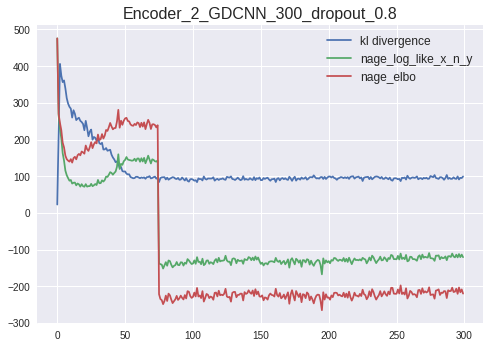

In [0]:
elbo_read = text_read('./result_0826/elbo_results.txt')
elbo_read = [-float(elbo) for elbo in elbo_read]

kl_read = text_read('./result_0826/kl_results.txt')
kl_read = [float(kl) for kl in kl_read]

likei_read = text_read('./result_0826/likei_results.txt')
likei_read = [-float(likei) for likei in likei_read]

plt.plot(kl_read, color = 'C0')
plt.plot(likei_read, color = 'C1')
plt.plot(elbo_read, color = 'C2')
plt.legend(['kl divergence','nage_log_like_x_n_y', 'nage_elbo'], fontsize=12)
plt.title("Encoder_2_GDCNN_300_dropout_0.8", fontsize=16)

|                                       |  Sub-train     | Test 1        |   Test 2    |  
|-----------------------------------|--------------------|-------------------|----------------|
|Reconstruction loss   | -213.30219 | -202.64314 |-203.7571  | 
| Nega_logp(x\z)          |  -104.58628 |-102.27634 |-103.01279   |
| Nega_logp(y\z)          |  -108.71591 | -100.36681 |--100.744286 |
|KL Divergence             | 15.922356   |14.511001    |14.691068  |
|ELBO                             | -229.22456 | -217.15414   |-218.44814  |

## Generate sentence

In [0]:
ind_small_txt =  6
        
en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"

en_input, en_input_len = generate_input_en(en_file, en_word_to_id, max_length)
fr_output, fr_output_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

en_input_batches, en_input_len_batches = batch_producer(en_input, en_input_len, batch_size) 
fr_output_batches, fr_output_len_batches = batch_producer(fr_output, fr_output_len, batch_size)

### Define functions

In [0]:
def find_next_word_beam_gene(logits_y, t):

  lower_ob = []
  for l in range(latent_num):           
    prob_y = np.exp(logits_y[l,t])/np.sum(np.exp(logits_y[l,t]))    
    log_prob_y_t = np.log(prob_y)     
    lower_ob.append(log_prob_y_t)
  
  lower_to = 0
  for l in range(latent_num):
    lower_to = lower_to + lower_ob[l] 
  lower_ave = lower_to/latent_num
  
  return lower_ave

In [0]:
def id_to_word(words, word_to_id, max_length):
  k=0
  sen_len=30
  sens = ["" for x in range(max_length+1)]
  for key in word_to_id.keys():
    for p in range(max_length):
      if words[p] == word_to_id[key]:
        sens[p] = key
      if words[p] == word_to_id['eos'] and k==0:
        sen_len = p
        k=k+1
  return sens, sen_len

def output_sentence(idd,x_de,y_de):
  ########## "English" ##########
  origin_sens, ori_len = id_to_word(en_input[idd], en_word_to_id, max_length)
  or_sens_str = " "
  for p in range(ori_len):
     or_sens_str = or_sens_str + " " + origin_sens[p]
  print("x:")
  print(or_sens_str)

  or_sens, or_len = id_to_word(x_de[-1], en_word_to_id, max_length)
  or_sens_str = " "
  for p in range(or_len):
    or_sens_str = or_sens_str + " " + or_sens[p]
  print("x_re:")
  print(or_sens_str)
  
  en_bleu = sentence_bleu([origin_sens[:ori_len]],or_sens[:or_len],weights=(1, 0, 0, 0))
  print(en_bleu)
  
  ########## "French" ##########
  origin_sens, ori_len = id_to_word(fr_output[idd], fr_word_to_id, max_length)
  or_sens_str = " "
  for p in range(ori_len):
     or_sens_str = or_sens_str + " " + origin_sens[p]
  print("y:")
  print(or_sens_str)

  or_sens, or_len = id_to_word(y_de[-1], fr_word_to_id, 30)
  or_sens_str = " "
  for p in range(or_len):
    or_sens_str = or_sens_str + " " + or_sens[p]
  print("y_re:")
  print(or_sens_str)
  
  fr_bleu = sentence_bleu([origin_sens[:ori_len]],or_sens[:or_len],weights=(1, 0, 0, 0))
  print(fr_bleu)

In [0]:
output_sentence(9,x_de,y_de)

x:
  I appeal for an in @-@ depth debate on this subject .
x_re:
  I appeal for this in @-@ depth debate on this subject .
0.9166666666666666
y:
  Je demande qu&apos; un débat approfondi soit mené sur ce sujet .
y_re:
  Je demande qu&apos; un débat européen a adopté sur ce sujet .
0.75


In [0]:
output_sentence(64,x_de,y_de)

x:
  I also wish to thank Mr Almunia for the assistance he has given Cyprus all this time in achieving this objective .
x_re:
  I also like to thank Mr Tajani for the work which has given this and this time , the this area .
0.5909090909090909


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


y:
  Je voudrais également remercier M . Almunia pour l&apos; aide qu&apos; il a apportée à Chypre pendant tout ce temps en vue d&apos; atteindre cet objectif .
y_re:
  Je voudrais également remercier M . Dalli pour l&apos; aide qu&apos; il a accompli à Cancún et tous le qui en vue d&apos; atteindre l&apos; objectif .
0.7037037037037037


In [0]:
output_sentence(89,x_de,y_de)

x:
  It is a mechanism that we have criticised here , in this Parliament , and that , I think , we continue to criticise .
x_re:
  It is a time that we have done here , in this House , and that , I think , we want to say .
0.8
y:
  C&apos; est un mécanisme que nous avons critiqué ici , dans ce Parlement , et que , je pense , nous continuons de critiquer .
y_re:
  C&apos; est un mécanisme que nous avons été , , dans ce Parlement , et que , je pense que nous continuerons de défendre .
0.84


In [0]:
output_sentence(77,x_de,y_de)

x:
  The issue of the euro is no small matter for our fellow citizens : it is , in their hands , one of the European Union &apos;s most valuable
x_re:
  The issue of the euro is no the way for the fellow citizens , it is , in our hands of it of the European Union &apos;s most complicated
0.7931034482758621
y:
  L&apos; affaire de l&apos; euro n&apos; est pas une petite affaire pour nos concitoyens : c&apos; est , entre leurs mains , un des biens les plus précieux de
y_re:
  L&apos; importance de l&apos; euro n&apos; est pas une nouvelle fois de nos concitoyens , c&apos; est , . les intérêts d&apos; un des citoyens de plus économiques car
0.6551724137931034


In [0]:
output_sentence(78,x_de,y_de)

x:
  Since last year , however , since the opening of the debate on the accession of Lithuania , we have had the impression that it has become a debate
x_re:
  Since last year , however , since the opening of the debate on the accession of N , we have had the impression that it has been a job
0.896551724137931
y:
  Pourtant , depuis l&apos; année dernière , depuis l&apos; ouverture du débat sur l&apos; adhésion de la Lituanie , nous avons l&apos; impression qu&apos; il est devenu un débat
y_re:
  Depuis , , l&apos; année dernière , dans l&apos; ouverture du débat sur l&apos; adhésion de la Commission , nous avons l&apos; impression qu&apos; il est devenu un Parlement
0.8275862068965517


### Beam Search

In [0]:
########## Beam Search gene x and y ###########

beam_size = 30
conti = True
idd = 9
t = 0
decode_len = 30

eos_id = en_word_to_id['eos']
eos_prob = -float('Inf')

x_in = np.reshape(np.copy(en_input[idd]), (1, max_length))
y_in = np.reshape(np.copy(fr_output[idd]), (1, max_length))

x_de = np.random.randint(low=0, high=en_vocab_size, size=(beam_size, max_length))
y_de = np.random.randint(low=0, high=fr_vocab_size, size=(beam_size, max_length))

x_len = np.reshape(np.copy(en_input_len[idd]), (1,))
y_len = np.reshape(np.copy(fr_output_len[idd]), (1,))

#########################################################
x_prob_next_word = np.ones((beam_size, en_vocab_size),dtype=np.float32)
x_de_new = np.zeros(x_de.shape, dtype=np.int32)
x_score = np.zeros((beam_size))

y_prob_next_word = np.ones((beam_size, fr_vocab_size),dtype=np.float32)
y_de_new = np.zeros(y_de.shape, dtype=np.int32)
y_score = np.zeros((beam_size))

#########################################################
with tf.Session() as sess:
  
    saver = tf.train.Saver()
    saver.restore(sess, path1)
    
    gene_feed_dict = {input_placeholder: x_in, 
                      target_placeholder: y_in,
                      in_length_placeholder: x_len, 
                      out_length_placeholder: y_len}                           
            
    mean, std = sess.run([la_mean, la_std], feed_dict=gene_feed_dict)    # 1*max_len x fr_vocab_size
    
    la_var = []
    log_prob_la = []
    for _ in range(latent_num):
      eposida = np.random.normal(size = np.shape(la_std), loc=0.0, scale=1)
      la_var_sample = mean + std*eposida
      la_var_sample = np.reshape(la_var_sample, (batch_size, max_length, latent_size))    # batch_size x max_length x latent_size
      la_var.append(la_var_sample)
      log_prob_la.append(np.sum(np.log(norm.pdf(la_var_sample))))
       
    for t in range(decode_len):
      
        for j in range(beam_size):
          gene_feed_dict = {if_gene_placeholder: True,
                            latent_var_placeholder:la_var,
                            input_placeholder: np.reshape(x_de[j], (1,max_length)),
                            target_placeholder: np.reshape(y_de[j], (1,max_length))}
                                                                           
          logits_x = sess.run(logits_gene_x_to, feed_dict=gene_feed_dict)
          
          logits_y = sess.run(logits_gene_y_to, feed_dict=gene_feed_dict)
            
          x_prob_next_word[j] = find_next_word_beam_gene(logits_x, t)          
          
          x_prob_next_word[j] = x_prob_next_word[j] + x_score[j]
          
          y_prob_next_word[j] = find_next_word_beam_gene(logits_y, t)          
          
          y_prob_next_word[j] = y_prob_next_word[j] + y_score[j]
        
        
        x_beam_id = np.argmax(x_prob_next_word, axis=0)
        
        x_prob_next_word_beam = np.max(x_prob_next_word, axis=0)
        
        x_next_word_id = np.argsort(x_prob_next_word_beam[2:])[-beam_size:] + 2
        
        y_beam_id = np.argmax(y_prob_next_word, axis=0)
        
        y_prob_next_word_beam = np.max(y_prob_next_word, axis=0)
        
        y_next_word_id = np.argsort(y_prob_next_word_beam[2:])[-beam_size:] + 2
        
        
        for j in range(beam_size):
          
          x_beam_id_j = x_beam_id[x_next_word_id[j]]
          
          x_word_id_j = x_next_word_id[j]
          
          x_de_new[j] = copy.deepcopy(x_de[x_beam_id_j])
              
          x_de_new[j,t] = copy.deepcopy(x_word_id_j)
          
          x_score[j] = copy.deepcopy(x_prob_next_word_beam[x_word_id_j])
          
          
          y_beam_id_j = y_beam_id[y_next_word_id[j]]
          
          y_word_id_j = y_next_word_id[j]
          
          y_de_new[j] = copy.deepcopy(y_de[y_beam_id_j])
              
          y_de_new[j,t] = copy.deepcopy(y_word_id_j)
          
          y_score[j] = copy.deepcopy(y_prob_next_word_beam[y_word_id_j])
        
        x_de = copy.deepcopy(x_de_new)
        y_de = copy.deepcopy(y_de_new)

INFO:tensorflow:Restoring parameters from ./result_0826/model_each_epch.ckpt


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [0]:
########## Beam Search gene x ###########

beam_size = 30
conti = True
idd = 64
t = 0
decode_len = 30

eos_id = en_word_to_id['eos']
eos_prob = -float('Inf')

x_in = np.reshape(np.copy(en_input[idd]), (1, max_length))

y_in = np.random.randint(low=0, high=fr_vocab_size, size=(1, max_length))

x_de = np.random.randint(low=0, high=en_vocab_size, size=(beam_size, max_length))
x_len = np.reshape(np.copy(en_input_len[idd]), (1,))

#########################################################
x_prob_next_word = np.ones((beam_size, en_vocab_size),dtype=np.float32)
x_de_new = np.zeros(x_de.shape, dtype=np.int32)
x_score = np.zeros((beam_size))


#########################################################
with tf.Session() as sess:
  
    saver = tf.train.Saver()
    saver.restore(sess, path1)
    
    gene_feed_dict = {input_placeholder: x_in, 
                      target_placeholder: y_in}                           
            
    mean, std = sess.run([la_mean, la_std], feed_dict=gene_feed_dict)    # 1*max_len x fr_vocab_size
    
    la_var = []
    log_prob_la = []
    for _ in range(latent_num):
      eposida = np.random.normal(size = np.shape(la_std), loc=0.0, scale=1)
      la_var_sample = mean + std*eposida
      la_var_sample = np.reshape(la_var_sample, (batch_size, max_length, latent_size))    # batch_size x max_length x latent_size
      la_var.append(la_var_sample)
      log_prob_la.append(np.sum(np.log(norm.pdf(la_var_sample))))
       
    for t in range(decode_len):
      
        for j in range(beam_size):
          gene_feed_dict = {if_gene_placeholder: True,
                            latent_var_placeholder:la_var,
                            input_placeholder: np.reshape(x_de[j], (1,max_length))}
                                                                           
          logits_x = sess.run(logits_gene_x_to, feed_dict=gene_feed_dict)
          
          x_prob_next_word[j] = find_next_word_beam_gene(logits_x, t)          
          
          x_prob_next_word[j] = x_prob_next_word[j] + x_score[j]
          
        x_beam_id = np.argmax(x_prob_next_word, axis=0)
        
        x_prob_next_word_beam = np.max(x_prob_next_word, axis=0)
        
        x_next_word_id = np.argsort(x_prob_next_word_beam[2:])[-beam_size:] + 2
        
        for j in range(beam_size):
          
          x_beam_id_j = x_beam_id[x_next_word_id[j]]
          
          x_word_id_j = x_next_word_id[j]
          
          x_de_new[j] = copy.deepcopy(x_de[x_beam_id_j])
              
          x_de_new[j,t] = copy.deepcopy(x_word_id_j)
          
          x_score[j] = copy.deepcopy(x_prob_next_word_beam[x_word_id_j])
          
        x_de = copy.deepcopy(x_de_new)

INFO:tensorflow:Restoring parameters from ./result_0826/model_each_epch.ckpt


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [0]:
def id_to_word(words, word_to_id, max_length):
  k=0
  sen_len=30
  sens = ["" for x in range(max_length+1)]
  for key in word_to_id.keys():
    for p in range(max_length):
      if words[p] == word_to_id[key]:
        sens[p] = key
      if words[p] == word_to_id['eos'] and k==0:
        sen_len = p
        k=k+1
  return sens, sen_len

def output_sentence(idd,x_de):
  ########## "English" ##########
  origin_sens, ori_len = id_to_word(en_input[idd], en_word_to_id, max_length)
  or_sens_str = " "
  for p in range(ori_len):
     or_sens_str = or_sens_str + " " + origin_sens[p]
  print("x:")
  print(or_sens_str)

  or_sens, or_len = id_to_word(x_de[-1], en_word_to_id, max_length)
  or_sens_str = " "
  for p in range(or_len):
    or_sens_str = or_sens_str + " " + or_sens[p]
  print("x_re:")
  print(or_sens_str)
  
  en_bleu = sentence_bleu([origin_sens[:ori_len]],or_sens[:or_len],weights=(1, 0, 0, 0))
  print(en_bleu)

In [0]:
output_sentence(9,x_de)

x:
  I appeal for an in @-@ depth debate on this subject .
x_re:
  As , to the , the &apos;s , on this &apos; .
0.25


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [0]:
output_sentence(64,x_de)

x:
  I also wish to thank Mr Almunia for the assistance he has given Cyprus all this time in achieving this objective .
x_re:
  I , , to the the &apos; of the , , has on this and the report , the this area .
0.3181818181818182


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


### Blue Score Functions

In [0]:
def count_ngram(candidate, references, n):
    clipped_count = 0
    count = 0
    r = 0
    c = 0
    for si in range(len(candidate)):
        # Calculate precision for each sentence
        ref_counts = []
        ref_lengths = []
        # Build dictionary of ngram counts
        for reference in references:
            ref_sentence = reference[si]
            ngram_d = {}
            words = ref_sentence.strip().split()
            ref_lengths.append(len(words))
            limits = len(words) - n + 1
            # loop through the sentance consider the ngram length
            for i in range(limits):
                ngram = ' '.join(words[i:i+n]).lower()
                if ngram in ngram_d.keys():
                    ngram_d[ngram] += 1
                else:
                    ngram_d[ngram] = 1
            ref_counts.append(ngram_d)
        # candidate
        cand_sentence = candidate[si]
        cand_dict = {}
        words = cand_sentence.strip().split()
        limits = len(words) - n + 1
        for i in range(0, limits):
            ngram = ' '.join(words[i:i + n]).lower()
            if ngram in cand_dict:
                cand_dict[ngram] += 1
            else:
                cand_dict[ngram] = 1
        clipped_count += clip_count(cand_dict, ref_counts)
        count += limits
        r += best_length_match(ref_lengths, len(words))
        c += len(words)
    if clipped_count == 0:
        pr = 0
    else:
        pr = float(clipped_count) / count
    bp = brevity_penalty(c, r)
    return pr, bp


def clip_count(cand_d, ref_ds):
    """Count the clip count for each ngram considering all references"""
    count = 0
    for m in cand_d.keys():
        m_w = cand_d[m]
        m_max = 0
        for ref in ref_ds:
            if m in ref:
                m_max = max(m_max, ref[m])
        m_w = min(m_w, m_max)
        count += m_w
    return count


def best_length_match(ref_l, cand_l):
    """Find the closest length of reference to that of candidate"""
    least_diff = abs(cand_l-ref_l[0])
    best = ref_l[0]
    for ref in ref_l:
        if abs(cand_l-ref) < least_diff:
            least_diff = abs(cand_l-ref)
            best = ref
    return best


def brevity_penalty(c, r):
    if c > r:
        bp = 1
    else:
        bp = math.exp(1-(float(r)/c))
    return bp


def geometric_mean(precisions):
    return (reduce(operator.mul, precisions)) ** (1.0 / len(precisions))


def sel_sentence_bleu(candidate, references):
    precisions = []
    for i in range(4):
        pr, bp = count_ngram(candidate, references, i+1)
        precisions.append(pr)
    bleu = geometric_mean(precisions) * bp
    return bleu

## Translate Sentence

In [0]:
def cal_kl_loss(mean,log_var,var ):
  kl_loss = 1 + log_var - np.square(mean) - var                      # batch_size*max_length x latent_size
  kl_loss = -0.5 * np.sum(kl_loss)                               # batch_size*max_length x 1
#   kl_div_loss = np.reshape(kl_div_loss, (batch_size, max_length))        # batch_size x max_length
#   kl_div_loss = np.sum(kl_div_loss, axis=1)
  return kl_loss

def id_to_word(words, word_to_id, max_length):
  k=0
  sen_len=30
  sens = ["" for x in range(max_length+1)]
  for key in word_to_id.keys():
    for p in range(max_length):
      if words[p] == word_to_id[key]:
        sens[p] = key
      if words[p] == word_to_id['eos'] and k==0:
        sen_len = p
        k=k+1
  return sens, sen_len

def find_next_word_beam_gene(logits_y, t):

  lower_ob = []
  for l in range(latent_num):           
    prob_y = np.exp(logits_y[l,t])/np.sum(np.exp(logits_y[l,t]))    
    log_prob_y_t = np.log(prob_y)     
    lower_ob.append(log_prob_y_t)
  
  lower_to = 0
  for l in range(latent_num):
    lower_to = lower_to + lower_ob[l] 
  lower_ave = lower_to/latent_num
  
  return lower_ave

def find_next_word_beam_gene_first(logits_y, log_prob_y, log_prob_la, t):

  lower_ob = []
  for l in range(latent_num):           
    prob_y = np.exp(logits_y[l,t])/np.sum(np.exp(logits_y[l,t]))    
    log_prob_y_t = np.log(prob_y)     
    lower_ob.append(log_prob_y_t)
  
  lower_to = 0
  for l in range(latent_num):
    lower_to = lower_to + lower_ob[l] + (log_prob_y[l] + log_prob_la[l])[0]
  lower_ave = lower_to/latent_num
  
  return lower_ave

def output_sentence(idd,x_de):
  ########## "English" ##########
  origin_sens, ori_len = id_to_word(en_input[idd], en_word_to_id, max_length)
  or_sens_str = " "
  for p in range(ori_len):
     or_sens_str = or_sens_str + " " + origin_sens[p]
  print("x:")
  print(or_sens_str)

  or_sens, or_len = id_to_word(x_de[-1], en_word_to_id, max_length)
  or_sens_str = " "
  for p in range(or_len):
    or_sens_str = or_sens_str + " " + or_sens[p]
  print("x_re:")
  print(or_sens_str)
  
  en_bleu = sentence_bleu([origin_sens[:ori_len]],or_sens[:or_len],weights=(1, 0, 0, 0))
  print(en_bleu)

In [47]:
########## "English" ##########
idd = 144
origin_sens, ori_len = id_to_word(en_input[idd], en_word_to_id, max_length)
or_sens_str = " "
for p in range(ori_len):
  or_sens_str = or_sens_str + " " + origin_sens[p]
print("x:")
print(or_sens_str)

origin_sens, ori_len = id_to_word(fr_output[idd], fr_word_to_id, max_length)
or_sens_str = " "
for p in range(ori_len):
  or_sens_str = or_sens_str + " " + origin_sens[p]
print("y:")
print(or_sens_str)

x:
  I strongly urge those other businesses that have not as yet joined this initiative to do so , without delay .
y:
  J&apos; invite instamment les entreprises qui n&apos; ont pas encore rejoint cette initiative à le faire sans plus tarder .


In [0]:
########## Beam Search translate x ###########

beam_size = 50
idd = 144
decode_len = 30

#### input y
x_true = np.reshape(np.copy(en_input[idd]), (1, max_length))
x_true_len = np.reshape(np.copy(en_input_len[idd]), (1,))

y_in = np.reshape(np.copy(fr_output[idd]), (1, max_length))
y_len = np.reshape(np.copy(fr_output_len[idd]), (1,))

x_len = np.reshape(np.copy(en_input_len[idd]), (1,))

#### initialize x
#x_in = np.concatenate((np.random.randint(low=0, high=en_vocab_size, size=(beam_size, x_len[0])), np.reshape(np.asarray(en_word_to_id['eos']),[1,1]), en_word_to_id['pad']*np.ones((1,max_length-x_len[0]-1),dtype=np.int32)), axis=1)
#x_in = np.random.randint(low=0, high=en_vocab_size, size=(1,  max_length))
x_in = en_word_to_id['<OOV>']*np.ones((1,  max_length),dtype=np.int32)
x_de = np.random.randint(low=0, high=en_vocab_size, size=(beam_size, max_length))

#### define useful variables
x_prob_next_word = np.ones((beam_size, en_vocab_size),dtype=np.float32)
x_de_new = np.zeros(x_de.shape, dtype=np.int32)
x_score = np.zeros((beam_size))


#########################################################

with tf.Session() as sess:
  
    saver = tf.train.Saver()
    saver.restore(sess, path1)
    
    for h in range(15):
      
      x_score = np.zeros((beam_size))
      
      #### sample latent variables
      gene_feed_dict = {input_placeholder: x_in, 
                        target_placeholder: y_in}                           
            
      mean, logvar, var, std = sess.run([la_mean, la_log_var, la_var, la_std], feed_dict=gene_feed_dict)                    # 1*max_len x fr_vocab_size
      kl_div = cal_kl_loss(mean, logvar, var)
      
      la_vari = []
      log_prob_la = []
      for _ in range(latent_num):
        eposida = np.random.normal(size = np.shape(la_std), loc=0.0, scale=1)
        la_var_sample = mean + std*eposida
        la_var_sample = np.reshape(la_var_sample, (batch_size, max_length, latent_size))   # batch_size x max_length x latent_size
        la_vari.append(la_var_sample)   
        log_prob_la.append(np.sum(norm.logpdf(la_var_sample)))

      la_vari = np.stack(la_vari,axis=0)                                                     # latent_num x batch_size x max_length x latent_size
      log_prob_la = np.stack(log_prob_la,axis=0)                                           # latent_num x 1
    
      #### obtain log p(y|z)
      gene_feed_dict = {latent_var_placeholder:la_vari,
                        target_placeholder: y_in,
                        input_placeholder: x_true,
                        in_length_placeholder: x_true_len,
                        out_length_placeholder: y_len}

      log_prob_x, log_prob_y = sess.run([log_liki_x_to,log_liki_y_to], feed_dict=gene_feed_dict)                       # latent_num x 1
      
      ind = np.argsort(log_prob_y[:,0])[-10:]
      new_la_var = copy.deepcopy(la_vari[ind])
      for i in range(4):
        new_la_var = np.concatenate((new_la_var,la_vari[ind]),axis=0)
      
      print(kl_div)
      print(np.sum(log_prob_la)/latent_num)
      print(np.sum(log_prob_x)/latent_num)
      print(np.sum(log_prob_y)/latent_num)
      
      #### beam search for x
    
      for t in range(decode_len):
      
        for j in range(beam_size):
          
          gene_feed_dict = {latent_var_placeholder:new_la_var,
                            input_placeholder: np.reshape(x_de[j], (1,max_length))}
                                                                           
          logits_x = sess.run(logits_gene_x_to, feed_dict=gene_feed_dict)
          
          if t==1:
            x_prob_next_word[j] = find_next_word_beam_gene_first(logits_x, log_prob_y, log_prob_la, t)          
            x_prob_next_word[j] = x_prob_next_word[j] + x_score[j]
          else:  
            x_prob_next_word[j] = find_next_word_beam_gene(logits_x, t)          
            x_prob_next_word[j] = x_prob_next_word[j] + x_score[j]
          
        x_beam_id = np.argmax(x_prob_next_word, axis=0)        
        x_prob_next_word_beam = np.max(x_prob_next_word, axis=0)     
        x_next_word_id = np.argsort(x_prob_next_word_beam[2:])[-beam_size:] + 2
              
        for j in range(beam_size):
          
          x_beam_id_j = x_beam_id[x_next_word_id[j]]
          
          x_word_id_j = x_next_word_id[j]
          
          x_de_new[j] = copy.deepcopy(x_de[x_beam_id_j])
              
          x_de_new[j,t] = copy.deepcopy(x_word_id_j)
          
          x_score[j] = copy.deepcopy(x_prob_next_word_beam[x_word_id_j])
        
        x_de = copy.deepcopy(x_de_new)
        
      #### at the end of beam search
      or_sens, or_len = id_to_word(x_de[-1], en_word_to_id, max_length)
      or_sens_str = " "
      for p in range(max_length):
        or_sens_str = or_sens_str + " " + or_sens[p]
      print("x_tran:")
      print(or_sens_str)
    
      x_in[0] = copy.deepcopy(x_de[-1])

In [0]:
######### Beam Search translate x ###########

beam_size = 50
idd = 144
decode_len = 30

#### input x
x_in = np.reshape(np.copy(en_input[idd]), (1, max_length))
x_len = np.reshape(np.copy(en_input_len[idd]), (1,))
y_len = np.reshape(np.copy(fr_output_len[idd]), (1,))

y_true = np.reshape(np.copy(fr_output[idd]), (1, max_length))
y_true_len = np.reshape(np.copy(fr_output_len[idd]), (1,))

#### initialize x
y_in = fr_word_to_id['<OOV>']*np.ones((1,  max_length),dtype=np.int32)
y_de = np.random.randint(low=0, high=en_vocab_size, size=(beam_size, max_length))

#### define useful variables
y_prob_next_word = np.ones((beam_size, fr_vocab_size),dtype=np.float32)
y_de_new = np.zeros(y_de.shape, dtype=np.int32)
y_score = np.zeros((beam_size))


#########################################################

with tf.Session() as sess:
  
    saver = tf.train.Saver()
    saver.restore(sess, path1)
    
    for h in range(15):
      
      y_score = np.zeros((beam_size))      
            
      #### sample latent variables
      gene_feed_dict = {input_placeholder: x_in, 
                        target_placeholder: y_in}                           
            
      mean, logvar, var, std = sess.run([la_mean, la_log_var, la_var, la_std], feed_dict=gene_feed_dict)                    # 1*max_len x fr_vocab_size
      kl_div = cal_kl_loss(mean, logvar, var)
      
      la_vari = []
      log_prob_la = []
      for _ in range(latent_num):
        eposida = np.random.normal(size = np.shape(la_std), loc=0.0, scale=1)
        la_var_sample = mean + std*eposida
        la_var_sample = np.reshape(la_var_sample, (batch_size, max_length, latent_size))   # batch_size x max_length x latent_size
        la_vari.append(la_var_sample)   
        log_prob_la.append(np.sum(norm.logpdf(la_var_sample)))

      la_vari = np.stack(la_vari,axis=0)                                                     # latent_num x batch_size x max_length x latent_size
      log_prob_la = np.stack(log_prob_la,axis=0)                                           # latent_num x 1
    
      #### obtain log p(y|z)
      gene_feed_dict = {latent_var_placeholder:la_vari,
                        target_placeholder: y_true,
                        input_placeholder: x_in,
                        in_length_placeholder: x_len,
                        out_length_placeholder: y_true_len}

      log_prob_x, log_prob_y = sess.run([log_liki_x_to,log_liki_y_to], feed_dict=gene_feed_dict)                       # latent_num x 1
      
      ind = np.argsort(log_prob_x[:,0])[-10:]
      new_la_var = copy.deepcopy(la_vari[ind])
      for i in range(4):
        new_la_var = np.concatenate((new_la_var,la_vari[ind]),axis=0)
      
#       new_la_var = la_vari
    
      print(kl_div)
      print(np.sum(log_prob_la)/latent_num)
      print(np.sum(log_prob_x)/latent_num)
      print(np.sum(log_prob_y)/latent_num)
      
      #### beam search for y
    
      for t in range(decode_len):
      
        for j in range(beam_size):
          
          gene_feed_dict = {latent_var_placeholder: new_la_var,
                            target_placeholder: np.reshape(y_de[j], (1,max_length))}
                                                                           
          logits_y = sess.run(logits_gene_y_to, feed_dict=gene_feed_dict)
          
          if t==1:
            y_prob_next_word[j] = find_next_word_beam_gene_first(logits_y, log_prob_x, log_prob_la, t)          
            y_prob_next_word[j] = y_prob_next_word[j] + y_score[j]
          else:  
            y_prob_next_word[j] = find_next_word_beam_gene(logits_y, t)          
            y_prob_next_word[j] = y_prob_next_word[j] + y_score[j]
         
        y_beam_id = np.argmax(y_prob_next_word, axis=0)        
        y_prob_next_word_beam = np.max(y_prob_next_word, axis=0)     
        y_next_word_id = np.argsort(y_prob_next_word_beam[2:])[-beam_size:] + 2
              
        for j in range(beam_size):
          
          y_beam_id_j = y_beam_id[y_next_word_id[j]]
          
          y_word_id_j = y_next_word_id[j]
          
          y_de_new[j] = copy.deepcopy(y_de[y_beam_id_j])
              
          y_de_new[j,t] = copy.deepcopy(y_word_id_j)
          
          y_score[j] = copy.deepcopy(y_prob_next_word_beam[y_word_id_j])
        
        y_de = copy.deepcopy(y_de_new)
        
      #### at the end of beam search
      or_sens, or_len = id_to_word(y_de[-1], fr_word_to_id, max_length)
      or_sens_str = " "
      for p in range(max_length):
        or_sens_str = or_sens_str + " " + or_sens[p]
      print("y_tran:")
      print(or_sens_str)
      
      y_in[0] =  y_de[-1]